---
# Basics of Mobile Robotics Project

# Image Processing

## Detect corner of the robot's environment
We want to get rid off all the random components introduced by taking a picture by hand. it's include translations, rotations, scaling and most importantly perspective transformations. Therefore we want to search four points, which we willingly place at known distances and angles from each other, to standardize our image. 

The best is to detect the four extreme angles of the rectangle environment. It's increases the precision of the transformation (smaller relative error on their distance to each other).
There are several ways to find these corner : 

- detect the lines of the rectangle (hough transform) but there will be to many line with obstacles.
- convolution with the corner pattern in the grayscale (surprisingly not efficient at all) advantage of being scale invariant but not at all rotation invariant
- convolution with specific pattern in the full color range (i.e. a pattern with a very specific color, easier to find) we chose a disk because it's rotation invariant the most important criter for convolution (not scale invarient but it's ok). by being the only object of a specific color in the plan it's supposed to be very easy to find but still some difficulties.

We chose the last option, the more efficient 

Here we import libraries and define usefull functions and variables

In [1]:
#!pip install scikit-image

In [45]:
import cv2
import numpy as np
import math
from skimage import morphology
import math
import matplotlib.pyplot as plt
from matplotlib import colors
np.random.seed(0) # To guarantee the same outcome on all computers


#variable definition
corner= np.zeros((4,2),np.uint32)  #matrix of the detected patterns' centers. int because thee are index
corner_sort = np.zeros((4,2),np.uint32)  #sorted matrix of the detected patterns' centers
distancex = 1200  #true distance of the robot environment
distancey =  800  #true distance of the robot environment
start = np.zeros(3,np.float32) #starting point of ther robot (x,y,angle). float to compute the angle
end = np.zeros(2,np.int32) #goal point (x,y)
centroid = np.zeros((2,3),np.int32) #centroids of the red disk and their number of points
robot_size_kernel = (15,15)#kernel of the size of the robot in pixel in the resized map
capt_point = (850,700)#point at which we emulate the sensing of an onboard camera
capt_xdim = 200#dimension of the simulated camera view
capt_ydim = 200
img_path = 'photos_test_3\IMG_5939.JPG'#if we take the image from the computer

goalReached = -100#is goal reached? terminate the program
capt_xdim = 200 #dimension of the emulated view, the bigger it is, the more the precision of the postion is
capt_ydim = 200
true_robot_length = 20#length between the center of the robot and a bit forward in pixels in the true map




#function definition


##################################################################################################
#Image processing functions__START
##################################################################################################
def stackImages(scale, imgArray):
    rows = len(imgArray)
    cols = len(imgArray[0])
    rowsAvailable = isinstance(imgArray[0], list)
    width = imgArray[0][0].shape[1]
    height = imgArray[0][0].shape[0]
    if rowsAvailable:
        for x in range(0, rows):
            for y in range(0, cols):
                if imgArray[x][y].shape[:2] == imgArray[0][0].shape[:2]:
                    imgArray[x][y] = cv2.resize(imgArray[x][y], (0, 0), None, scale, scale)
                else:
                    imgArray[x][y] = cv2.resize(imgArray[x][y], (imgArray[0][0].shape[1], imgArray[0][0].shape[0]),
                                                None, scale, scale)
                if len(imgArray[x][y].shape) == 2: imgArray[x][y] = cv2.cvtColor(imgArray[x][y], cv2.COLOR_GRAY2BGR)
        imageBlank = np.zeros((height, width, 3), np.uint8)
        hor = [imageBlank] * rows
        hor_con = [imageBlank] * rows
        for x in range(0, rows):
            hor[x] = np.hstack(imgArray[x])
        ver = np.vstack(hor)
    else:
        for x in range(0, rows):
            if imgArray[x].shape[:2] == imgArray[0].shape[:2]:
                imgArray[x] = cv2.resize(imgArray[x], (0, 0), None, scale, scale)
            else:
                imgArray[x] = cv2.resize(imgArray[x], (imgArray[0].shape[1], imgArray[0].shape[0]), None, scale, scale)
            if len(imgArray[x].shape) == 2: imgArray[x] = cv2.cvtColor(imgArray[x], cv2.COLOR_GRAY2BGR)
        hor = np.hstack(imgArray)
        ver = hor
    return ver

def display(output, fact = 0.3):
    cv2.namedWindow("output", cv2.WINDOW_NORMAL )  # Create window with freedom of dimensions
    cv2.resizeWindow("output", math.floor ( fact * output.shape [1] ) , math.floor (fact * output.shape [0] ) )  # Resize window to specified dimensions keeping the image form
    cv2.imshow("output", output)
    cv2.waitKey ( 0 )
    
def angle(x0,y0,x1,y1):
    #directly put the angle in the start array
    dist = math.sqrt ( (x0 - x1)*(x0 - x1) + (y0 - y1)*(y0 - y1)  )
    x = (x1 - x0)/dist#normalisation required
    y = (y1 - y0)/dist
    start[2] = math.acos(x)
    
def prepare_image(path):
    #read the image saved in path and return it in RGB mode
    img = cv2.imread(path)
    u,v,d = img.shape
    if (u>v):#if needed rotate the image to have a horizontal one
        img = cv2.rotate(img,cv2.ROTATE_90_CLOCKWISE)
    imgHSV = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    return img

def get_clean_map(img) :
    #find the blue corner, make them wite, and map the image to get a nice map
    #return true_map, the map in high resolution

    #mask to get the blue color
    imgHSV = cv2.cvtColor ( img , cv2.COLOR_BGR2HSV )
    [h_min, s_min, v_min] = [90,138,108]
    [h_max, s_max, v_max] = [130,255,255]
    lower = np.array([h_min, s_min, v_min])
    upper = np.array([h_max, s_max, v_max])
    mask = cv2.inRange(imgHSV, lower, upper)

    #for robustness and avoid useless labeling, remove all the noisy blue isolated pixels
    img_dilate = cv2.dilate ( mask , np.ones ( (10 , 10) , np.uint8 ) , iterations=1 )
    img_erode = cv2.erode(img_dilate,np.ones((10,10),np.uint8),iterations = 2)
    img_dilate = cv2.dilate(img_erode,np.ones((10,10),np.uint8),iterations = 1)

    #put the same number to all connected pixels:
    labels = morphology.label(img_dilate, background=0)
    #seek for the four biggest blobs i.e. the four labels with the most of pixels
    #It's a robustness mesure : the four corners are supposed to have the same size and being much bigger than not wanted regions
    unique_labels = (np.unique(labels))[1:]
    comptage = np.zeros(unique_labels.size+1)
    for i in unique_labels :
        comptage[i] = np.sum(labels==i)
    indice = np.argsort(comptage)
    error =0
    if (np.max(indice)<4):
        return img
    for i in range(0,4):#take the four biggest labels
        ett_current = np.where(labels==(indice[indice.size-1-i]),1,0)
        #erase the blue pixels not to detect them again
        img [: , : , 0] = np.where ( labels == (indice [indice.size - 1 - i]) , 200 , img [: , : , 0] )
        img [: , : , 1] = np.where ( labels == (indice [indice.size - 1 - i]) , 200 , img [: , : , 1] )
        img [: , : , 2] = np.where ( labels == (indice [indice.size - 1 - i]) , 200 , img [: , : , 2] )
        #compute the centroids of each blob, they are the corner of the map
        ett_current = np.float32(ett_current)
        M = cv2.moments (ett_current)
        cX =  int ( M ["m10"] / M ["m00"] )
        cY =  int ( M ["m01"] / M ["m00"] )
        corner[i , :] = np.array([cX,cY])

    #sort the corner
    x_max = max(corner[:,0])
    x_min = min(corner[:,0])
    y_max = max(corner[:,1])
    y_min = min(corner[:,1])
    x_middle = (x_max-x_min)/2+x_min
    y_middle = (y_max-y_min)/2+y_min
    for i in range(0,4):
        if (corner[i,0]<x_middle) & (corner[i,1]<y_middle):
            corner_sort[0,:]=corner[i,:]
        if (corner [i , 0] < x_middle) &  (corner [i , 1] > y_middle) :
            corner_sort [1 , :] = corner [i , :]
        if (corner [i , 0] > x_middle) &  (corner [i , 1] < y_middle) :
            corner_sort [2 , :] = corner [i , :]
        if (corner [i , 0] > x_middle) &  (corner [i , 1] > y_middle) :
            corner_sort [3 , :] = corner [i , :]
    #apply resizing
    corner_goal = np.array([[0,0],[0,distancey], [distancex,0], [distancex,distancey]], np.float32)
    M = cv2.getPerspectiveTransform(np.float32(corner_sort),corner_goal)
    img_reconstruct = cv2.warpPerspective(img, M,(distancex,distancey))
    true_map = img_reconstruct
    return true_map

def robot_detection(map):
    #return the position of the robot (x,y,angle) angle between the direction where the robot is going and the lower abscisse axis

    #filter red component from the map
    imgHSV2 = cv2.cvtColor ( map, cv2.COLOR_BGR2HSV )
    [h_min , s_min , v_min] = [0 , 160 , 0]
    [h_max , s_max , v_max] = [180 , 255 , 255]
    lower = np.array ( [h_min , s_min , v_min] )
    upper = np.array ( [h_max , s_max , v_max] )
    mask = cv2.inRange ( imgHSV2 , lower , upper )

    # detect the big and the small blob
    img_erode = cv2.erode ( mask , np.ones ( (10 , 10) , np.uint8 ) , iterations=1 )
    img_dilate = cv2.dilate ( img_erode , np.ones ( (10 , 10) , np.uint8 ) , iterations=1 )
    labels = morphology.label ( img_dilate , background=0 )
    unique_labels = (np.unique ( labels )) [1 :]
    comptage = np.zeros ( unique_labels.size + 1 )
    for i in unique_labels :
        comptage [i] = np.sum ( labels == i )
    indice = np.argsort ( comptage )

    
    plt.imshow(img_dilate)
    
    for i in range ( 0 , 2 ) :  # take the 2 biggest labels
        ett_current = np.where ( labels == (indice [indice.size - 1 - i]) , 1 , 0 )
        ett_current = np.float32 ( ett_current )
        sum = np.sum ( ett_current )
        M = cv2.moments ( ett_current )
        cX = int ( M ["m10"] / M ["m00"] )
        cY = int ( M ["m01"] / M ["m00"] )
        centroid [i , :] = np.array ( [cX , cY , sum] )
    #The biggest blob give the position (x,y) of the robot, we use also the small one to compute the angle
    imax = np.argmax ( centroid [: , 2] )
    imin = 1 - imax
    start [0 :2] = centroid [imax , 0 :2]
    angle ( centroid [imax, 0], centroid [imax, 1] , centroid [ imin, 0] ,centroid [imin,1]  )
    return start

def goal_detection(img_reconstruct):
    # detect the goal point

    #filter the green component
    imgHSV3 = cv2.cvtColor ( img_reconstruct , cv2.COLOR_BGR2HSV )
    [h_min , s_min , v_min] = [47 , 89 , 51]
    [h_max , s_max , v_max] = [116 , 209 , 198]
    lower = np.array ( [h_min , s_min , v_min] )
    upper = np.array ( [h_max , s_max , v_max] )
    mask = cv2.inRange ( imgHSV3 , lower , upper )


    #Here we consider there are not to much not wanted pixel in the mask
    #so we consider after erosion the only pixels to one are those from the goal
    img_erode = cv2.erode ( mask , np.ones ( (15 , 15) , np.uint8 ) , iterations=1 )
    img_dilate = cv2.dilate ( img_erode , np.ones ( (15 , 15) , np.uint8 ) , iterations=1 )

    M = cv2.moments ( img_dilate )
    cX = int ( M ["m10"] / M ["m00"] )
    cY = int ( M ["m01"] / M ["m00"] )
    end = np.array ( [cX , cY] )
    return end

def get_global_search_map(for_global_search):
    #return the map dilate to make obstacles a bit bigger to take into account the size of the robot

    #here we get ride of all thin black lines used for online positioning
    map_gray = cv2.cvtColor ( for_global_search , cv2.COLOR_BGR2GRAY )
    map_dilate = cv2.dilate ( map_gray , np.ones ( (4 , 4) , np.uint8 ) , iterations=1 )
    map_erode = cv2.erode ( map_dilate , np.ones ( (4 , 4) , np.uint8 ) , iterations=1 )

    ret , map_bin = cv2.threshold ( map_erode , 50 , 255 , cv2.THRESH_BINARY )#apply a fixed threshold binarization
    map_bin = 255 - map_bin
    #increase the size of the obstacles
    map_global_search = cv2.dilate ( map_bin , np.ones ( robot_size_kernel , np.uint8 ) , iterations=1 )
    return map_global_search

def camera_emulation(true_map) :
    # emulate onboard camera return the emulated view, a rectangle a bit in front of the detected robot position
    # detect robot's position

    pos = robot_detection ( true_map )  # detect the position of the robot on the map

    # crop the image to have a small rectangle in front of the robot
    capt_point = np.array ( [pos [1] - capt_ydim , pos [0]] ) + true_robot_length * np.array (
        [-math.sin ( pos [2] ) , +math.cos ( pos [2] )] )  # the bottom left point of the emulated view
    capt_point = np.int32 ( capt_point )
    capt_rect = true_map [capt_point [0] : capt_point [0] + capt_xdim , capt_point [1] : capt_point [1] + capt_ydim]
    # display the filmed region by highlighting it
    true_map [capt_point [0] : capt_point [0] + capt_xdim , capt_point [1] : capt_point [1] + capt_ydim] = true_map [
                                                                                                           capt_point [
                                                                                                               0] :
                                                                                                           capt_point [
                                                                                                               0] + capt_xdim ,
                                                                                                           capt_point [
                                                                                                               1] :
                                                                                                           capt_point [
                                                                                                               1] + capt_ydim] + 40

    # get the probable position of the robot by convolving the emulated view with the map
    res = cv2.matchTemplate ( true_map , capt_rect , eval ( 'cv2.TM_CCOEFF_NORMED' ) )
    min_val , max_val , min_loc , max_loc = cv2.minMaxLoc ( res )

    # find the center of the robot from max_loc, top left point of convolution template
    estimated_posx = max_loc [0] - math.floor ( true_robot_length * math.cos ( pos [2] ) )
    estimated_posy = max_loc [1] + capt_ydim + math.floor ( true_robot_length * math.sin ( pos [2] ) )
    cv2.rectangle(true_map, (estimated_posx , estimated_posy), (estimated_posx +10, estimated_posy+10), 255,2)

    return np.array ( [estimated_posx , estimated_posy] )
##################################################################################################
#Image processing functions___END
##################################################################################################
    

In the following code we use the HSV representation to find the four blue corner and from them transform the image. Next we look for the orientation of the robot with the two red disk (two because we want position and orientation). Next we find the goal position with the green circle. And finally we determine a smaller version, binarized and with bit expnaded obstacles of the map to apply path finding.

In [3]:
#load img from computer
#img = prepare_image(img_path)#We load the image, we rotate it if needed to have a horizontal image.
#or get it from the webcam
#cap = cv2.VideoCapture(1)#put 1 if an external webcam is used
#cap.set(3,1200)#width
#cap.set(4,1000)#height
#success, img = cap.read()
#display(img)


#true_map = get_clean_map(img)
#for_global_search = cv2.resize(true_map, (100,50))#apply resizing to reduce computation cost of global search
#start = robot_detection(for_global_search)#starting point for global search
#end = goal_detection(for_global_search)#ending point for global search
#map_global_search = get_global_search_map(for_global_search)
#map_bin = map_global_search
#print('start :',start)
#print('goal :', end)
#display(for_global_search)

# Global Map

## Different Approaches
Different approaches exist to find an optimal global path. In the beginning a visibility graph was implemented. To find the shortest path from start to goal Dijkstra’s algorithm was used. Due to difficulties of detecting the corners of the objects a new approach had to be implemented. 
Therefore a cell decomposition/grid based approach was implemented.
### Dijkstra - grid array

To find the optimal path from the start to end position Dijkstra’s algorithm is used on a binary grid array. The grid array represents free spaces with a zero and obstacles (that the robot has to navigate around) with a one. For the implementation a modified version of the code from the Exercise session 5 of the course MICRO-452  “Basics of mobile robotics” was used:

In [4]:
def create_empty_plot(max_val_row, max_val_column):
    """
    Helper function to create a figure of the desired dimensions & grid
    
    :param max_val_row: dimension of the map along the y dimension
    :param max_val_column: dimension of the map along the x dimension
    :return: the fig and ax objects.
    """
    fig, ax = plt.subplots(figsize=(15,10))
    
    major_ticks_row = np.arange(0, max_val_row+1, 5)
    minor_ticks_row = np.arange(0, max_val_row+1, 1)
    major_ticks_column = np.arange(0, max_val_column+1, 5)
    minor_ticks_column = np.arange(0, max_val_column+1, 1)
    ax.set_xticks(major_ticks_column)
    ax.set_xticks(minor_ticks_column, minor=True)
    ax.set_yticks(major_ticks_row)
    ax.set_yticks(minor_ticks_row, minor=True)
    ax.grid(which='minor', alpha=0.2)
    ax.grid(which='major', alpha=0.5)
    ax.set_ylim([0,max_val_row])
    ax.set_xlim([0,max_val_column])
    ax.grid(True)
    
    return fig, ax
#max_val_row=100
#max_val_column=200
#test=create_empty_plot(max_val_row, max_val_column)
#print(test)

In [5]:
def _get_movements_4n():
    """
    Get all possible 4-connectivity movements (up, down, left right).
    :return: list of movements with cost [(dx, dy, movement_cost)]
    """
    return [(1, 0, 1.0),
            (0, 1, 1.0),
            (-1, 0, 1.0),
            (0, -1, 1.0)]

def _get_movements_8n():
    """
    Get all possible 8-connectivity movements. Equivalent to get_movements_in_radius(1)
    (up, down, left, right and the 4 diagonals).
    :return: list of movements with cost [(dx, dy, movement_cost)]
    """
    s2 = math.sqrt(2)
    return [(1, 0, 1.0),
            (0, 1, 1.0),
            (-1, 0, 1.0),
            (0, -1, 1.0),
            (1, 1, s2),
            (-1, 1, s2),
            (-1, -1, s2),
            (1, -1, s2)]

#movements=_get_movements_4n()
#for move in movements:
#    print(move[0:2])

In [6]:
def A_Star(start, goal, h, coords, occupancy_grid, max_val_column, max_val_row, movement_type="8N"):
    """
    A* for 2D occupancy grid. Finds a path from start to goal.
    h is the heuristic function. h(n) estimates the cost to reach goal from node n.
    :param start: start node, tuple (x, y)
    :param goal_m: goal node, tuple (x, y)
    :param occupancy_grid: numpy array containing the map with the obstacles. At each position, 
                           you either have the number 1 (occupied) or 0 (free)
    :param movement: string, select between 4-connectivity ('4N') and 8-connectivity ('8N', default)
    :return: a tuple that contains: (the resulting path in meters, the resulting path in data array indices)
    """
    
    # Check if the start and goal are within the boundaries of the map
#     for point in [start, goal]:
#         assert point[0]>=0 and point[0]<max_val_column, "start or end goal not contained in the map"
#         assert point[1]>=0 and point[1]<max_val_row, "start or end goal not contained in the map"
    
    # check if start and goal nodes correspond to free spaces
    if occupancy_grid[start[0], start[1]]:
        print(start[0], start[1])
        raise Exception('Start node is not traversable')

    if occupancy_grid[goal[0], goal[1]]:
        print(goal[0], goal[1])
        raise Exception('Goal node is not traversable')
    
    # get the possible movements corresponding to the selected connectivity
    if movement_type == '4N':
        movements = _get_movements_4n()
    elif movement_type == '8N':
        movements = _get_movements_8n()
    else:
        raise ValueError('Unknown movement')
    
    
    # --------------------------------------------------------------------------------------------
    # A* Algorithm implementation - feel free to change the structure / use another pseudo-code
    # --------------------------------------------------------------------------------------------
    
    
    # Here we initialise the variables, feel free to print them or use the variable info function if it is not
    # what they contain or how to access the different elements
    
    # The set of visited nodes that need to be (re-)expanded, i.e. for which the neighbors need to be explored
    # Initially, only the start node is known.
    openSet = [start]
    
    # The set of visited nodes that no longer need to be expanded.
    # Note that this is an addition w.r.t. the wikipedia pseudocode
    # It contains the list of variables that have already been visited 
    # in order to visualise them in the plots
    closedSet = []

    # For node n, cameFrom[n] is the node immediately preceding it on the cheapest path from start to n currently known.
    cameFrom = dict()

    # For node n, gScore[n] is the cost of the cheapest path from start to n currently known.
    gScore = dict(zip(coords, [np.inf for x in range(len(coords))]))
    gScore[start] = 0

    # For node n, fScore[n] := gScore[n] + h(n). map with default value of Infinity
    fScore = dict(zip(coords, [np.inf for x in range(len(coords))]))
    fScore[start] = h[start]

    
    # while there are still nodes to visit 
    while len(openSet)!=0:
        
        #find the unvisited node having the lowest fScore[] value
        node_min_fScore_value=np.inf
        for node in openSet:
            if fScore[node]<node_min_fScore_value:
                node_min_fScore_value=fScore[node]
                current=node
        
        #If the goal is reached, reconstruct and return the obtained path
        if current==goal:
            path=[goal]
            while current!=start:
                current=cameFrom[current]
                path.append(current)
            return path, closedSet
        openSet.remove(current)
        closedSet.append(current)
        # If the goal was not reached, for each neighbor of current:
        for dx, dy, deltacost in movements:
            
            neighbor = (current[0]+dx, current[1]+dy)
            
            # if the node is not in the map, skip
            if neighbor not in coords:
                continue
                
            # if the node is occupied or has already been visited, skip
            if occupancy_grid[neighbor[0], neighbor[1]] or neighbor in closedSet:
                continue
                
            # compute the cost to reach the node through the given path
            tentative_gScore = gScore[current]+deltacost
            
            # If the computed cost is the best one for that node, then update the costs and 
            # node from which it came
            if tentative_gScore<gScore[neighbor]:
                # This path to neighbor is better than any previous one. Record it!
                cameFrom[neighbor]=current
                gScore[neighbor]=tentative_gScore
                fScore[neighbor]=gScore[neighbor]+h[neighbor]
                if neighbor not in openSet:
                    openSet.append(neighbor)

    # Open set is empty but goal was never reached
    print("No path found to goal")
    return [], [] #DUMMY VALUE - TO BE CHANGED


In [7]:
def generate_global_path(start, goal, occupancy_grid):  
    #get max_val_row and column
    max_val_row=occupancy_grid.shape[0]
    max_val_column=occupancy_grid.shape[1]
    
    # EXECUTION AND PLOTTING OF THE ALGORITHM     
    # List of all coordinates in the grid
    x,y=np.mgrid[0:max_val_column:1, 0:max_val_row:1]
    pos = np.empty(x.shape + (2,))
    pos[:,:,0] = y 
    pos[:,:,1] = x
    pos = np.reshape(pos, (x.shape[0]*x.shape[1], 2))
    coords = list([(int(x[0]), int(x[1])) for x in pos])


    # Define the heuristic, here = distance to goal ignoring obstacles
    h = np.linalg.norm(pos - goal, axis=-1)
    h = dict(zip(coords, h))

    # Run the A* algorithm
    path, visitedNodes = A_Star(start, goal, h, coords, occupancy_grid, max_val_column, max_val_row, movement_type="8N")
    path = np.array(path).reshape(-1, 2).transpose()
    visitedNodes = np.array(visitedNodes).reshape(-1, 2).transpose()

    # Displaying the map
    fig_astar, ax_astar = create_empty_plot(max_val_row, max_val_column)
    ax_astar.imshow(occupancy_grid, cmap=colors.ListedColormap(['white', 'red']))

    # Plot the best path found and the list of visited nodes
    ax_astar.scatter(visitedNodes[1], visitedNodes[0], marker="o", color = 'orange');
    ax_astar.plot(path[1], path[0], marker="o", color = 'blue');
    ax_astar.scatter(start[1], start[0], marker="o", color = 'green', s=200);
    ax_astar.scatter(goal[1], goal[0], marker="o", color = 'purple', s=200);
    
    return path

In [8]:
#occupancy_grid = np.asarray(map_bin)
#occupancy_grid=np.flipud(occupancy_grid)#change coordinate system

#start = np.int32(start)
#path=generate_global_path((occupancy_grid.shape[0]-start[1], start[0]), (occupancy_grid.shape[0]-end[1], end[0]), occupancy_grid)
#path=np.fliplr(np.flipud(path.T))


#convert path from pixel of field (max_val_row x max_val_column) into pixel of field (800mm x 1200mm)
#max_val_row=occupancy_grid.shape[0]
#max_val_column=occupancy_grid.shape[1]
#path[:,0]=path[:,0]*1200/max_val_column
#path[:,1]=path[:,1]*800/max_val_row

#print(f"path (form goal to start)")
#print(path)

### Testing Dijkstra - grid array
Following function allow the testing of the Dijkstra's allgorithm on a binary grid array, without needing all the setup (robot and surrounding).

In [9]:
def idx_neighborhood(pos, size):
    """
    generates the indexes of the neighborhood around a given position
    :param pos: position around which the indxses of the neighborhood will be generated
    :param size: size of the neighborhood
    :return: array with indexes of elements of neighborhood
    """
    idx=[[] for _ in range(size)] 
    for column in range(size):
        for row in range(size):
            idx[column].append((pos[0]-math.floor(size/2)+row, pos[1]+math.floor(size/2)-column))
    
    return idx


#idx=idx_neighborhood([5,5], 3)
#print(idx)

In [10]:
def incert_array(array, array_to_incert, pos):
    """
    makes a logic OR of the array_to_invert and the neighborhood around pos of array
    :param array: array which is modified
    :param array_to_incert: array that is incerted
    :param pos: position where array_to_incert is inserted
    :return: array with array_to_incert incerted (at position pos)
    """
    idx=idx_neighborhood(pos, len(array_to_incert))
    for column, val_row in enumerate(idx):
        for row, pos_idx in enumerate(val_row):
            if pos_idx[0]>=array.shape[0] or pos_idx[1]>=array.shape[1]:
                continue
            if pos_idx[0]<0 or pos_idx[1]<0:
                continue
            array[pos_idx]+=array_to_incert[(row,len(idx)-1-column)]
    array[array>=1]=1
    return array

#size=10
#ran_object=np.zeros((10, 20))   
#ran_object[5,5]=1
#data = np.zeros((3,3))
#data[1,1]=2
#data[2,2]=1
#print(data)

#ran_object=incert_array(ran_object, data, [1,1])
#print(ran_object)

In [11]:
def creat_random_object(size):#creates random object
    """
    generates a random object saved in array of given size
    :param size: arrays proportion
    :return: array containing random object
    """
    limit=90
    if size==0:
        return np.zeros((1, 1))
    ran_object=np.zeros((size, size))
    ran_object[round(size/2), round(size/2)]=1#"center" of object
    for k in range(round(size/2)):
        for column, val_row in enumerate(ran_object):
            for row, val_pixel in enumerate(val_row):
                if val_pixel==1:
                    data = np.random.rand(3, 3)*100
                    data[data<limit]=0
                    data[data>=limit]=1
                    ran_object=incert_array(ran_object, data, (row, column))
    return ran_object
#ran_object=creat_random_object(10)
#print(ran_object)

In [12]:
def create_random_occupancy_grid(max_val_column, max_val_row):
    """
    generates a occupancy_grid with a random amound of objects of random size and position
    :param max_val_column: maximum number of columns/ maximal value of x
    :param max_val_row: maximum number of rows/ maximal value of y
    :return occupancy_grid: array containing map
    :return cmap: color map of objects and free spaces
    """
    fig, ax = create_empty_plot(max_val_row, max_val_column)

    # Creating the occupancy grid
    # np.random.seed(0) # To guarantee the same outcome on all computers
    data = np.random.rand(max_val_row, max_val_column) * 1000 # Create a grid of 50 x 50 random values
    cmap = colors.ListedColormap(['white', 'red']) # Select the colors with which to display obstacles and free cells

    # Converting the random values into occupied "centers" and free cells
    limit = 999
    occupancy_grid = data.copy()
    occupancy_grid[data>limit] = 1
    occupancy_grid[data<=limit] = 0
    occupancy_grid_temp = occupancy_grid.copy()

    for column, val_row in enumerate(occupancy_grid):
        for row, val_pixel in enumerate(val_row):
            if val_pixel==1:
                occupancy_grid_temp=incert_array(occupancy_grid_temp, creat_random_object(np.random.randint(max_val_row/6,max_val_row/3)), (column, row))
    occupancy_grid=occupancy_grid_temp
    # Displaying the map
    ax.imshow(occupancy_grid, cmap=cmap)
    plt.title("Map : free cells in white, occupied cells in red");
    
    return occupancy_grid, cmap

    
    
    
#max_val_column = 200 # Size of the map
#max_val_row=100
#occupancy_grid, cmap=create_random_occupancy_grid(max_val_column, max_val_row)
#print(occupancy_grid.shape)

In [13]:
# Define start and end goal -> values have to be changed, that the are on empty spot and that a path between them exists
#test_start=(0,0)#value has to be changed
#test_goal=(99,199)#value has to be changed
#path=generate_global_path(test_start, test_goal, occupancy_grid)
#print(f"path (form goal to start)")
#print(f"x={path[1]}")
#print(f"y={path[0]}")

# Control

Once the path planning has been done, we need to get the Thymio robot to follow the planned path.
We do so by implementing a pilot, which uses knowledge of the robot's location relative to its next goal to calculate the motor inputs necessary to reach this goal. 

Unfortunately, the robot does not always have perfect knowledge of its position at all times, so it must be estimated from the limited measurements it does have access to, namely
- motor odometry
- ground IR sensors 
- horizontal proximity sensors

Because both the movement process and these measurements are quite noisy, simply dead reckoning the robot's position is not accurate enough. We need to implement a stochasitc state estimator to try to estimate the robot's position from the noisy measurements.

> <img src="./imgs/control-Page-1.png" />

> *Figure 1: Control diagram of the robot and pilot*

## Estimator
A number of stochastic estimation methods exist. The approach chosen in this project, the Kalman Filter, is computationally one of the simplest. It was chosen in the hopes of making the system more reactive. The Kalman filter is normally used for systems with linear behavior, but it can relatively easily be extended to non-linear systems that do not vary too abruptly:
$$ \begin{eqnarray}
\bar{\mathbf x} &=& g(\hat{\mathbf x}, \mathbf u)\\
\bar{s} &=& G_{\mathbf x,\mathbf u}\cdot s\cdot G_{\mathbf x,\mathbf u}^T\\
K       &=& \bar{s}\cdot C^T\cdot (C\cdot\bar{s}\cdot C^T + R)^{-1}\\
\hat{\mathbf x} &=& \bar{\mathbf x} + K(\mathbf y-C\bar{\mathbf x})\\
s       &=& (I - K C)\cdot \bar{s}
\end{eqnarray}$$

## Control Signal
The Thymio robot may be controlled throught its two motors. Our control signal $\mathbf u$ will therefore be : 
$$ \mathbf u = \begin{bmatrix} u_r\\ u_l \end{bmatrix}$$

## State 
The state of the robot $\mathbf x$ is defined as follows :
$$ \mathbf{x} = \begin{bmatrix}x\\ y \\ \phi \\ v_r \\ v_l\end{bmatrix}$$
where $[x , y]^T$ are the robot's position in space, $\phi$ is its angular orientation with respect to the x-axis, and $[v_r , v_l]^T$ are the speed on the right and left wheels, respectively. 

> <img src="./imgs/control-Page-2.png" style="width: 400px;"/>

> *Figure 2: definition of the robot pose*

## Motion Model
To apply the extended Kalman Filter, we need to define a motion model $\mathbf x^{+} = g(\mathbf{x,u})$. 
The simplest motion model for a robot such as the Thymio can be calculated in two steps. First, the intermediary values describing the change in angle and in distance are calculated:  
$$ \begin{bmatrix}dl\\ d\phi\end{bmatrix} = B\cdot \mathbf u$$ 

for $B=c \cdot T_s\begin{pmatrix} 0.5 & 0.5 \\  \frac{1}{d} & -\frac{1}{d} \end{pmatrix}$, where $T_s$ is the sample time and $d$ is the distance between the wheels. $c$ is a conversion constant to convert between Thymio speed and $mm/s$. 
Then the actual states may then be approximated as:
$$\begin{eqnarray}
\phi^{+} &=& \phi + d\phi\\
x^{+}    &=& x + dl \cdot cos(\phi^{+})\\
y^{+}    &=& y + dl \cdot sin(\phi^{+})\\
v_r^{+}  &=& u_r\\
v_l^{+}  &=& u_l
\end{eqnarray}$$

In order to linearize the motion model for use in the Kalman filter, we must calculate its Jacobian: $$G_{\mathbf{x,u}} = \begin{bmatrix} 
\frac{\partial g}{\partial x}(\mathbf{x,u}) &
\frac{\partial g}{\partial y}(\mathbf{x,u}) & 
\frac{\partial g}{\partial \phi}(\mathbf{x,u}) & 
\frac{\partial g}{\partial v_r}(\mathbf{x,u}) & 
\frac{\partial g}{\partial v_l}(\mathbf{x,u}) 
\end{bmatrix}$$

This can be done analytically, but it is too tedious for this report. The result can be found in the code in the file Robot.py.

Finally, we must estimate the uncertainty added by an update step of the motion process. We can measure the uncertainty on the motion process by wheel, which gives us $\mathbf{q} = \begin{bmatrix} q_r \\ q_l \end{bmatrix}$ resulting in a coviariance matrix $Q_{\mathbf u}$ with diagonal $\mathbf{q}$.
We can then apply the propagation of covariance formula though the linearized system (the Jacobian $G_{\mathbf{x,u}}$) in order to estimate the uncertainty on the robot state gained due to noise for a single process step:
$$ Q = G_{\mathbf{x,u}} \begin{pmatrix} \mathbf 0 & 0 \\ 0& Q_{\mathbf{u}}\end{pmatrix} G_{\mathbf {x,u}}^T$$
**Note:** This is in fact illegal. The real probablity density of the error added to the robot's state is highly non-linear. It follows a banana-shape, as the anguar uncertainty is much larger than the distance uncertainty. However, it was estimate(d) that the robot would have ample chance to localize itself and thus reduce the uncertainty to a level where the non-linearity doesn't matter as much.


## Sensor interpretation 

As mentioned above, the robot has access to several sensors which give it information about the world surrounding it. 
In our application, the sensors available to us do not allow a reversible mapping into state-space (i.e: the sensor function $\mathbf y = h(\mathbf x)$ is non-invertible). This is because the map is made up of a repeating grid, so we have no information on the absolute localization, and furthermore from the pont of view of the sensor, there is no way to tell whether the detected line is horizontal or vertical.
We must therefore do a preprocessing step on the raw sensor values to put them into a useable form for our (over)extended Kalman estimator.

A first approach was, whenever a line was detected by a sensor to simply take the coordinate of the closest gridline to the estimated position of that sensor as the "measured value" $\tilde{\mathbf y}$. This approach however does not take into account the fact that the estimated postion of the robot can be quite uncertain, so the returned "measured values" are very often wrong.

A different approach is to incorporate our estimated uncertainty into the sensor interpretation. Instead of looking for the closest gridline, we look for the most likely coordinates in which we could encounter a gridline, as shown in figure 3 below. These are then taken as $\tilde{\mathbf y}$.
This approach was adapted from : https://www.cs.cmu.edu/~motionplanning/papers/sbp_papers/integrated2/machler_grid_odometry.pdf



> <img src="./imgs/pdf-based_lacation_estimate.png" alt="pdf-based_lacation_estimate" style="width: 400px;"/>

> *Figure 3 : PDF-based location estimation. The real position of the sensor in space is unkown, so it is modelled as multivariate gaussian probability density function. When a gridline is encountered, we can calculate the position on the gridlines with the highest probablilty, and take this as our new position estimate.*

In [14]:
import os
import sys
import time
import serial
import matplotlib.pylab as plt
import numpy as np
from threading import Timer
from IPython import display as ds

# Adding the src folder in the current directory as it contains the necessary scripts
sys.path.insert(0, os.path.join(os.getcwd(), 'src'))

from Thymio import Thymio
import Field
import Robot
import util

In [15]:
# we use a bit of code from the course to make threads that can run in parallel
class RepeatedTimer(object):
    def __init__(self, interval, function, *args, **kwargs):
        self._timer     = None
        self.interval   = interval
        self.function   = function
        self.args       = args
        self.kwargs     = kwargs
        self.is_running = False
        self.start()

    def _run(self):
        self.is_running = False
        self.start()
        self.function(*self.args, **self.kwargs)

    def start(self):
        if not self.is_running:
            self._timer = Timer(self.interval, self._run)
            self._timer.start()
            self.is_running = True

    def stop(self):
        self._timer.cancel()
        self.is_running = False

In [41]:
def robot_thread(field, robot, goals, camera_pos):
    """ do the robot control cycle """

    if not goals :
            rt.stop()   #this is kind of bad, but i'm no python expert, so it'll have to do
            return 0

    u,local_obstacle = robot.pilot(goals)

    if not local_obstacle :
        robot.do_motion(u)

    sensor_data = robot.do_measure()
    
    if local_obstacle : 
        u = sensor_data[3:5,:]
        u[u>2**15] = u[u>2**15] - 2**16

    y = robot.sensor_interpretation(sensor_data, field)

    if camera_pos.x.size :                                    # if a camera position is available, update
        c0 = np.concatenate((np.eye(3), np.zeros((3,2))), axis = 1)
        y0 = camera_pos.x[0:3,:]
        r0 = np.array([.1, .1, .01])**2                           # we assume the camera position is the most precise possible
        robot.R = np.diag(np.concatenate((r0, np.diag(robot.R)), axis=0))  
        robot.C = np.concatenate((c0, robot.C))
        y = np.concatenate((y0, y), axis=0)
        camera_pos.x = np.array([])

    xtemp, stemp = robot.kalman_estimator(u, y)

    robot.xodo = robot.motion_model(robot.xodo, u)             # make a purely odometry-based estimate, for visual comparison

    field.xhat  = np.concatenate((field.xhat, xtemp), axis=1)
    field.xodo  = np.concatenate((field.xodo, robot.xodo), axis=1)
    field.s.append(2*np.sqrt(stemp[0,0]+stemp[1,1]))  
        
        
def camera_thread(field, cap, camera_pos) : 
    """ do the camera position acquisition cycle """
    
    success, img = cap.read()                                  # read the image from the  fixed camera
    true_map     = get_clean_map(img)                          # get the clean in good resolution
    
    plt.imshow(np.flipud(np.array(true_map)), origin = 'lower')
    
    x = util.adapt_vision_coords(robot_detection(true_map), field)# detect the position of the robot on the map
    x[0] = x[0] - 30
    
    field.xreal = np.concatenate((field.xreal, x), axis=1)
    camera_pos.x = x.copy()

# Local Avoidance Protocol

# TEST

In [38]:
robot      = Robot.NewRobot()                                                   # robot 
field      = Field.NewField(1200, 800, 200, 4)                                  # table

robot.th   = Thymio.serial(port="COM15", refreshing_rate=0.1)                   # set up Thymio communication

[604 407   2]


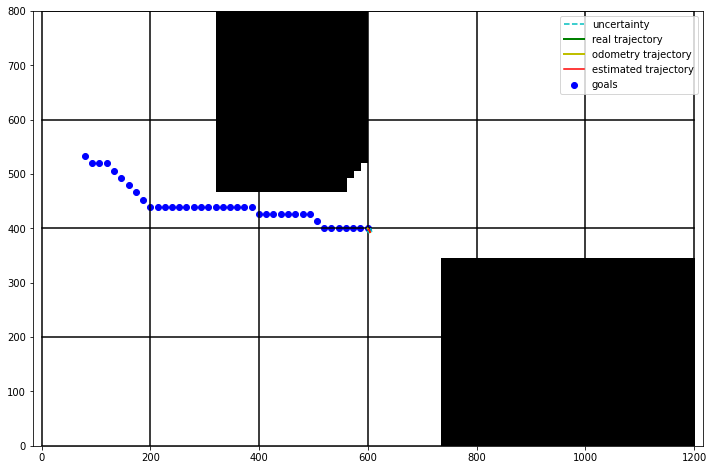

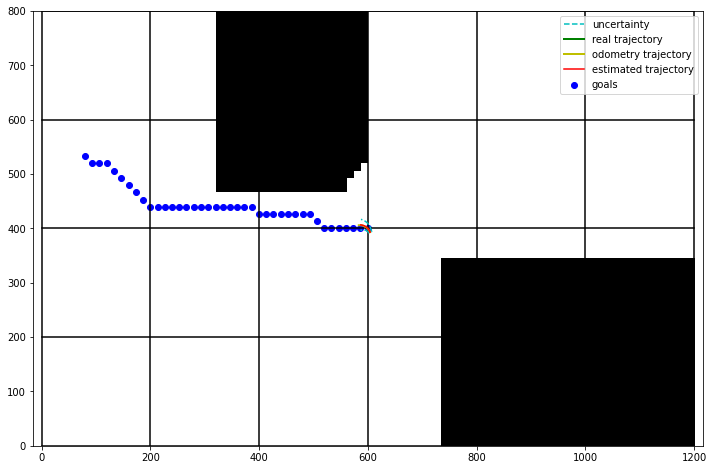

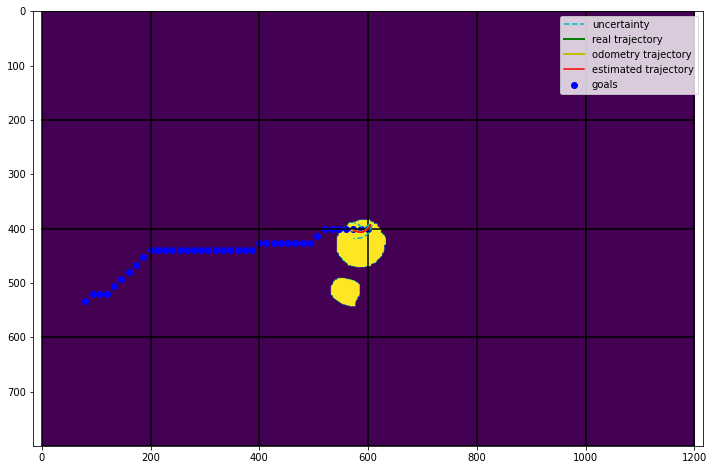

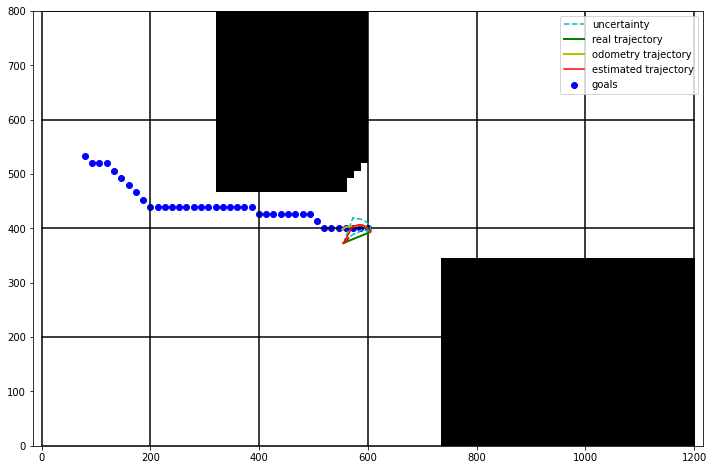

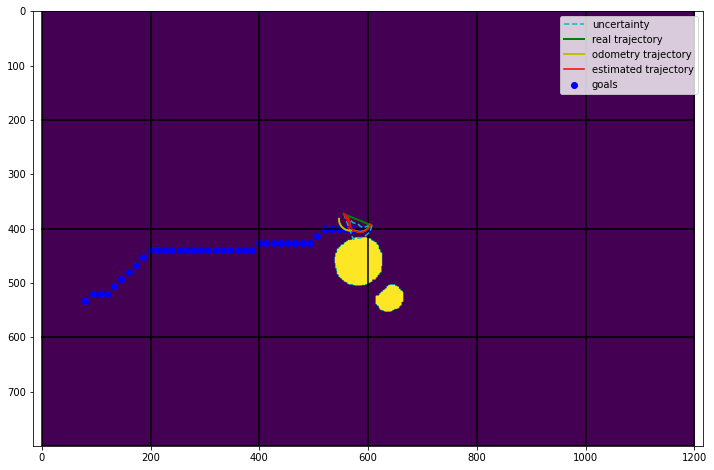

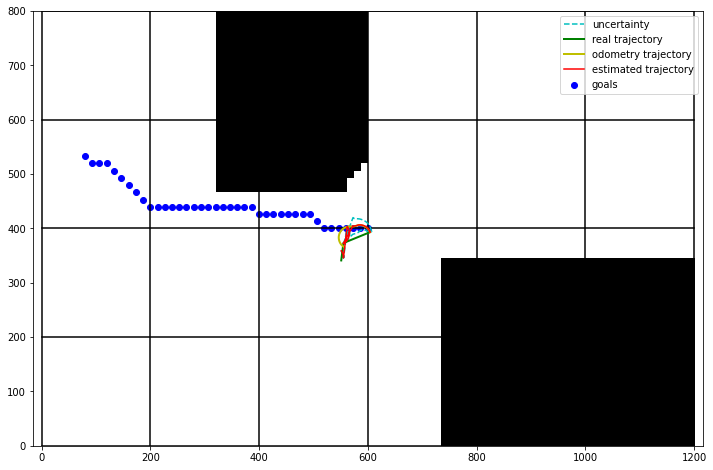

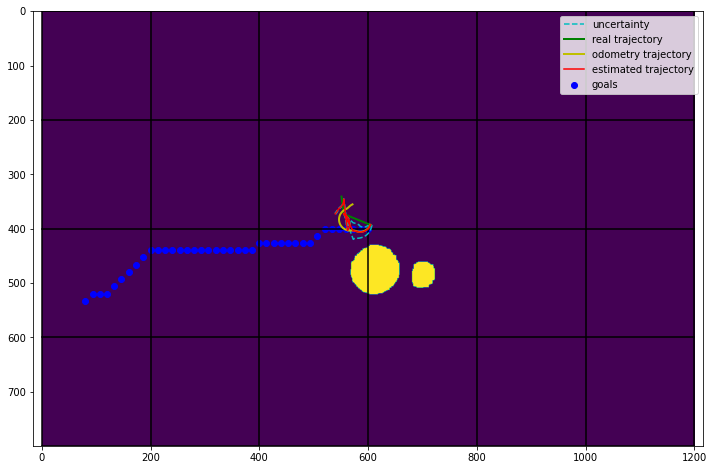

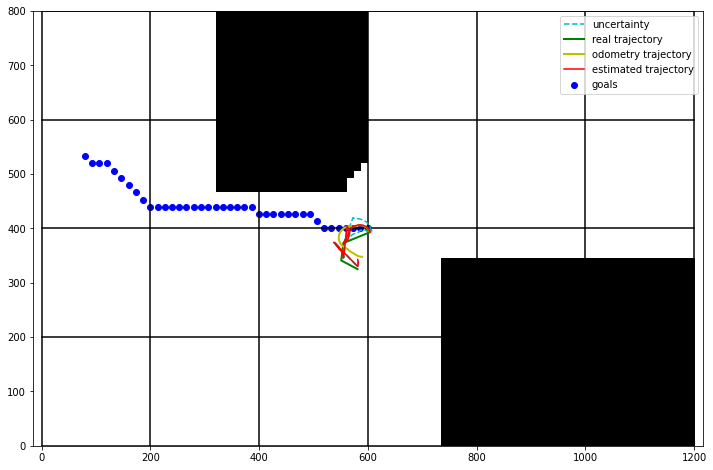

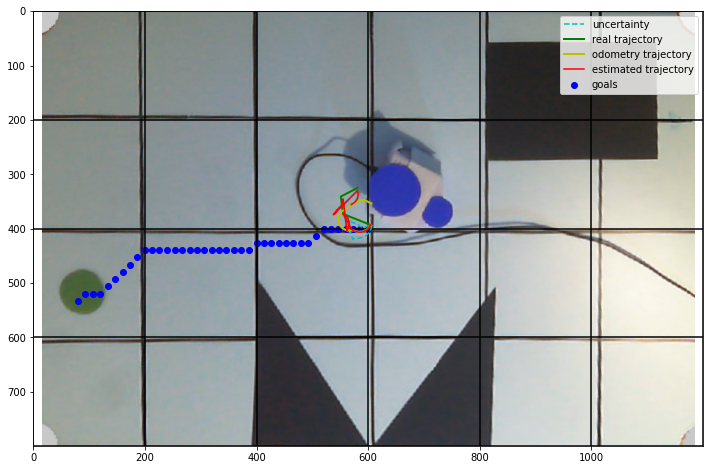

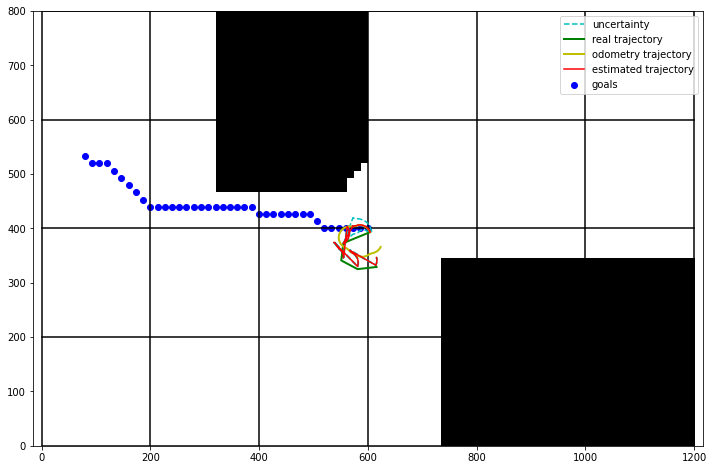

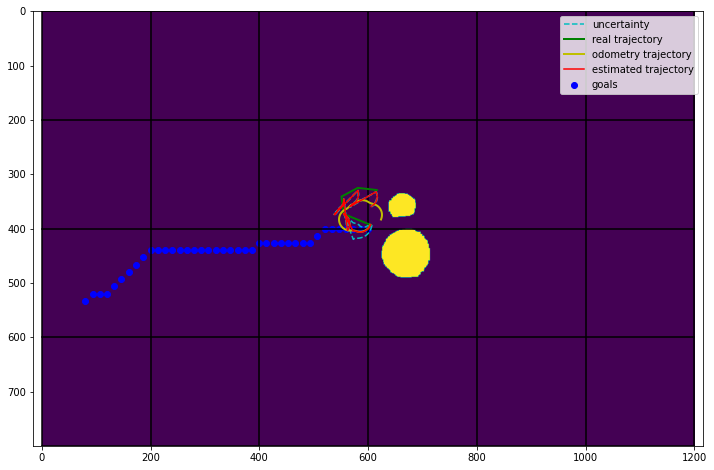

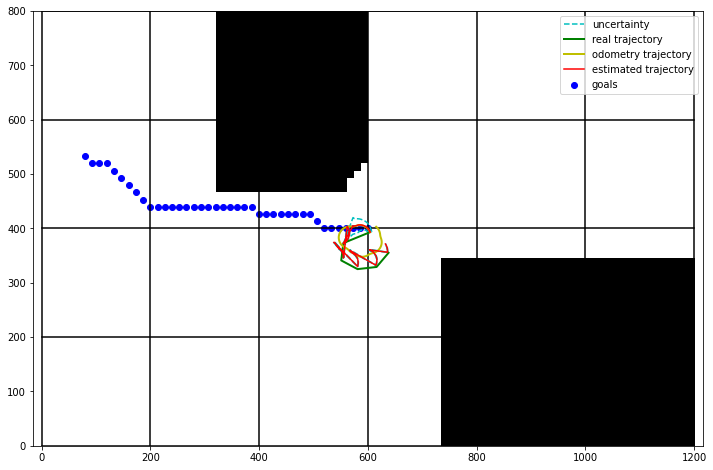

<ipython-input-45-0a6f84a8613f>:180: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.imshow(img_dilate)
Exception in thread Thread-5974:
Traceback (most recent call last):
  File "c:\users\michael biselx\appdata\local\programs\python\python38-32\lib\threading.py", line 932, in _bootstrap_inner
    self.run()
  File "c:\users\michael biselx\appdata\local\programs\python\python38-32\lib\threading.py", line 1254, in run
    self.function(*self.args, **self.kwargs)
  File "<ipython-input-15-09611c5246a3>", line 15, in _run
  File "<ipython-input-41-ea4e665ff31f>", line 47, in camera_thread
  File "<ipython-input-45-0a6f84a8613f>", line 180, in robot_detection
  File "c:\users\michael biselx\appdata\local\prog

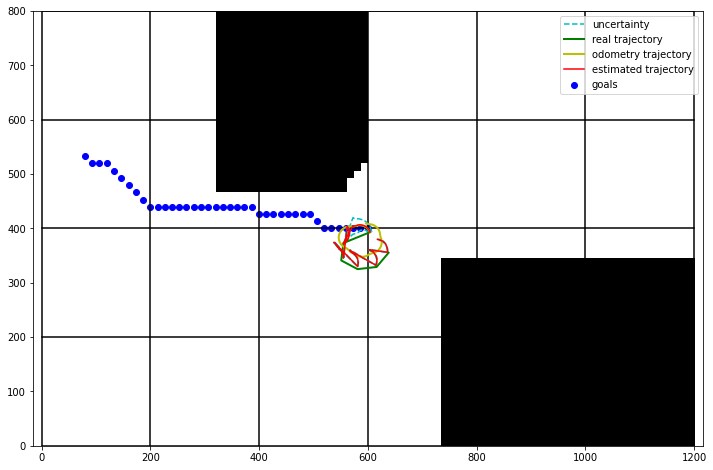

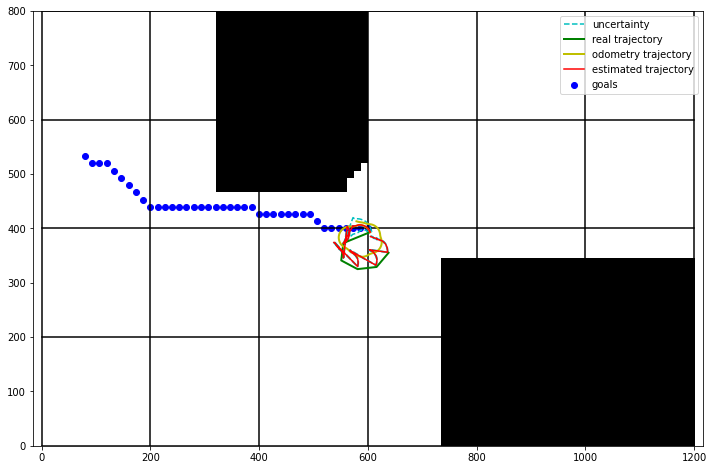

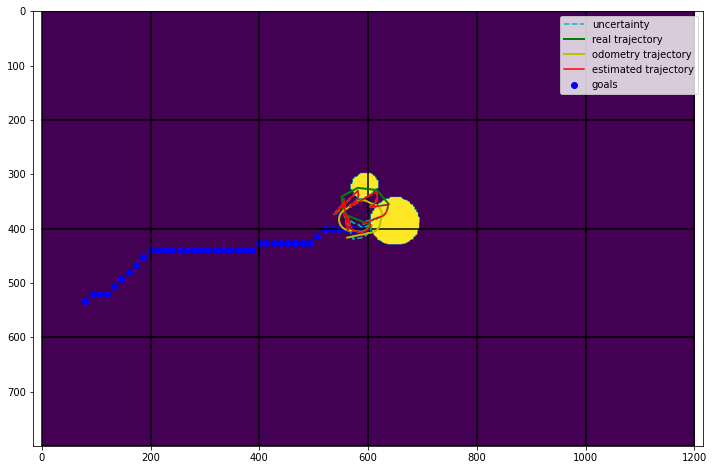

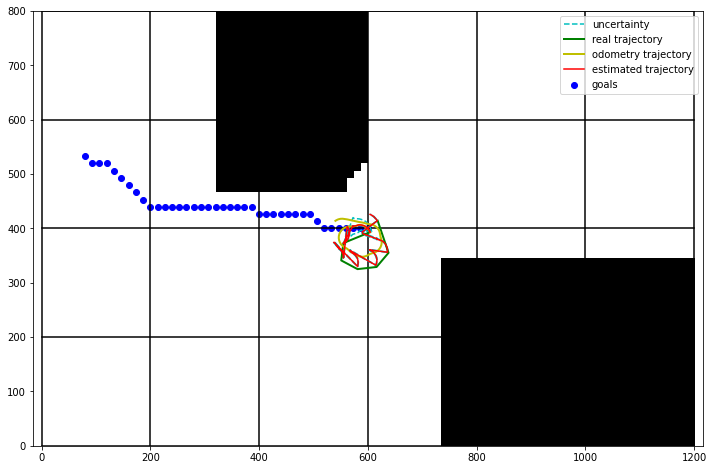

Exception in thread Thread-6015:
Traceback (most recent call last):
  File "c:\users\michael biselx\appdata\local\programs\python\python38-32\lib\threading.py", line 932, in _bootstrap_inner
    self.run()
  File "c:\users\michael biselx\appdata\local\programs\python\python38-32\lib\threading.py", line 1254, in run
    self.function(*self.args, **self.kwargs)
  File "<ipython-input-15-09611c5246a3>", line 15, in _run
  File "<ipython-input-41-ea4e665ff31f>", line 45, in camera_thread
  File "c:\users\michael biselx\appdata\local\programs\python\python38-32\lib\site-packages\matplotlib\pyplot.py", line 2731, in imshow
    sci(__ret)
  File "c:\users\michael biselx\appdata\local\programs\python\python38-32\lib\site-packages\matplotlib\pyplot.py", line 3102, in sci
    return gca()._sci(im)
  File "c:\users\michael biselx\appdata\local\programs\python\python38-32\lib\site-packages\matplotlib\axes\_base.py", line 1856, in _sci
    raise ValueError("Argument must be an image, collection, or

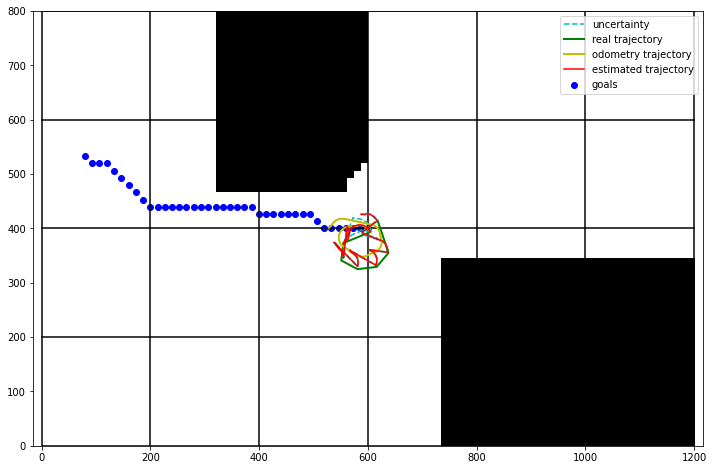

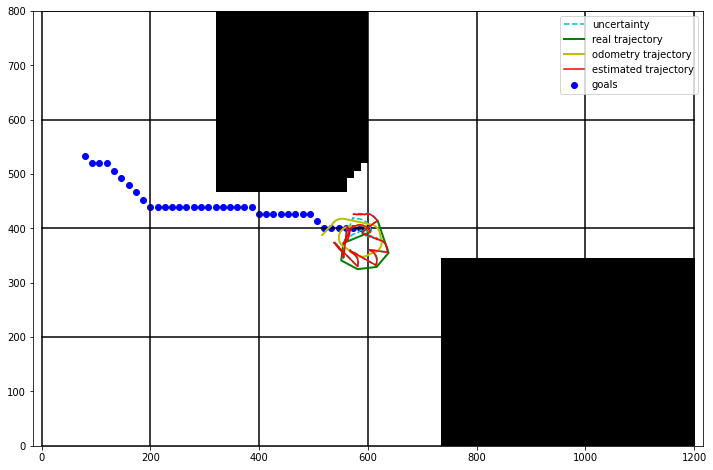

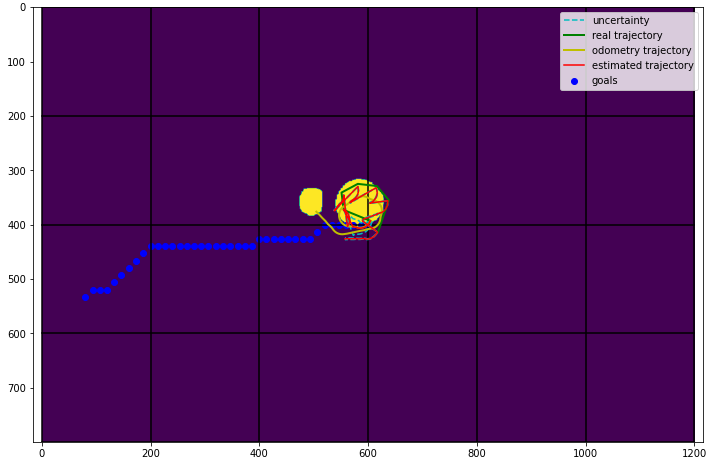

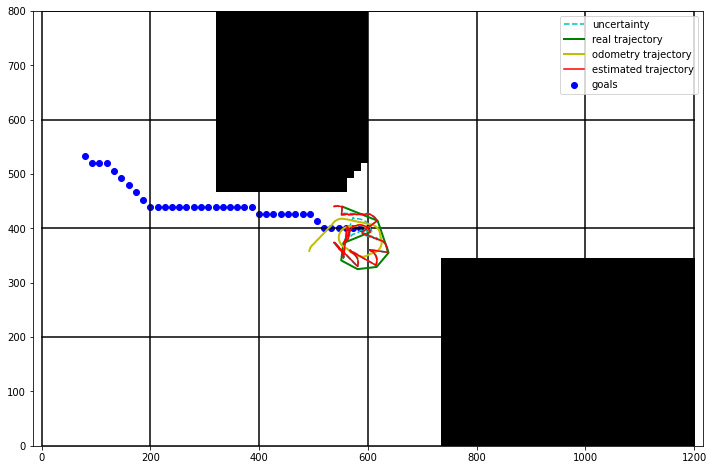

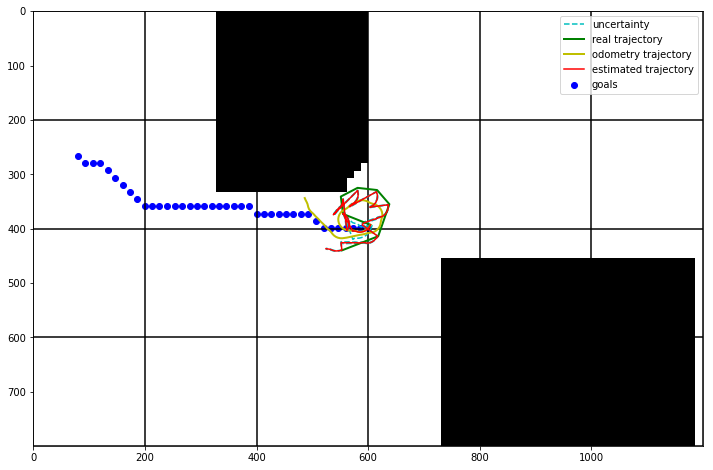

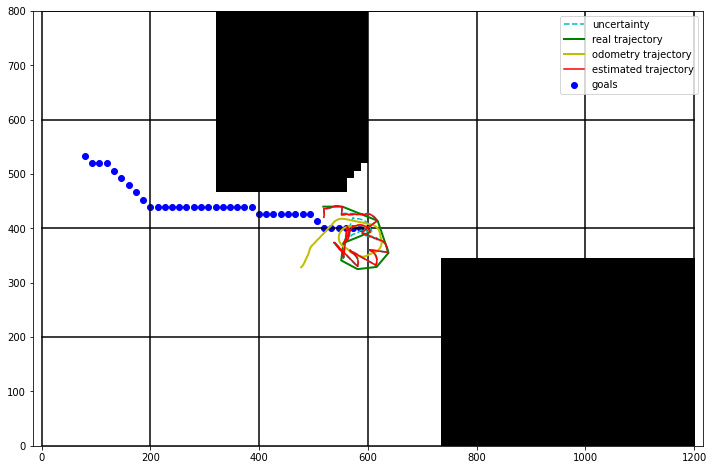

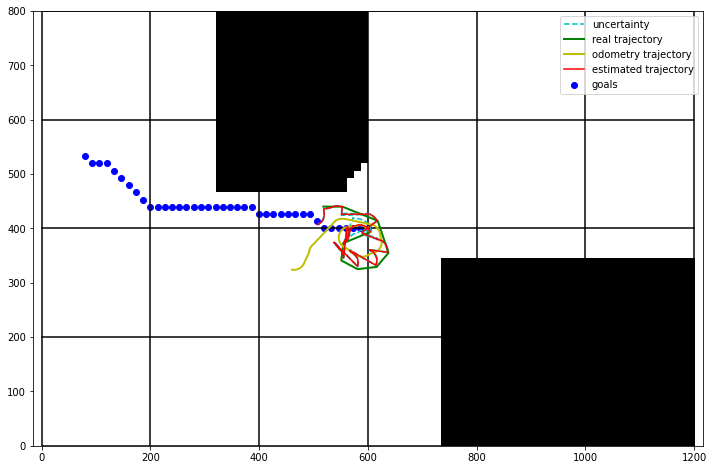

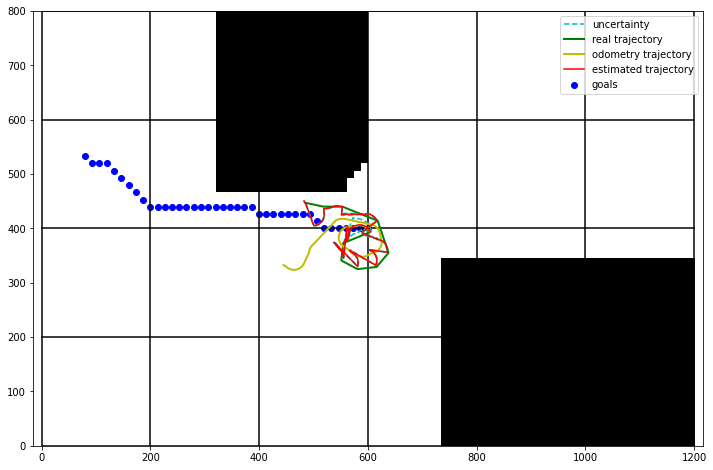

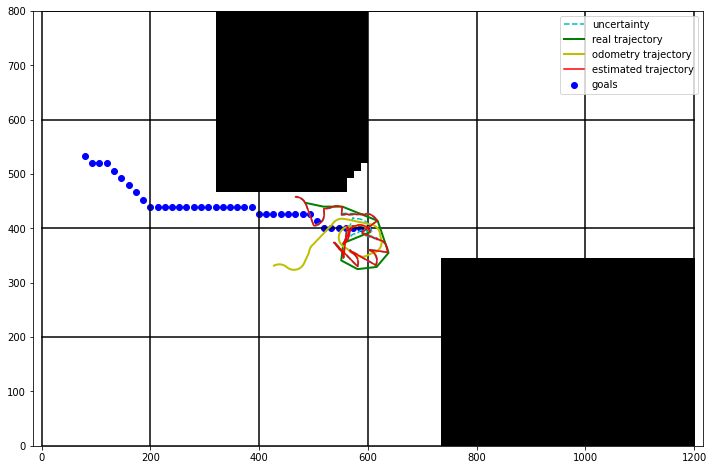

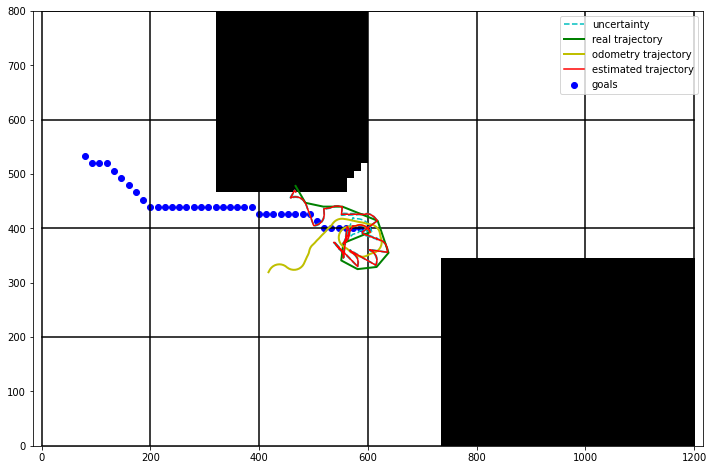

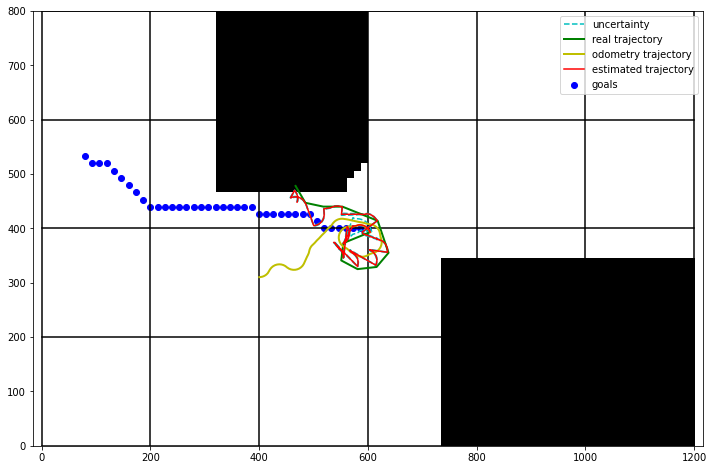

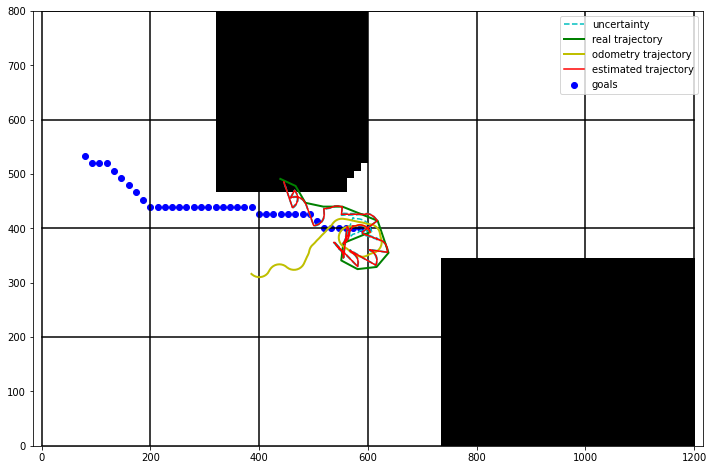

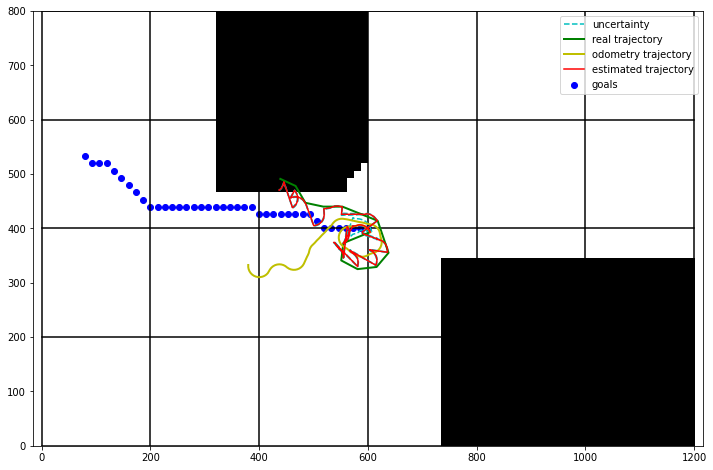

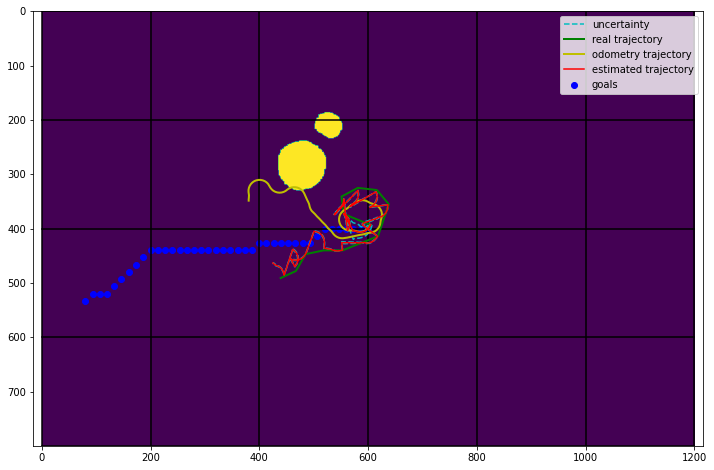

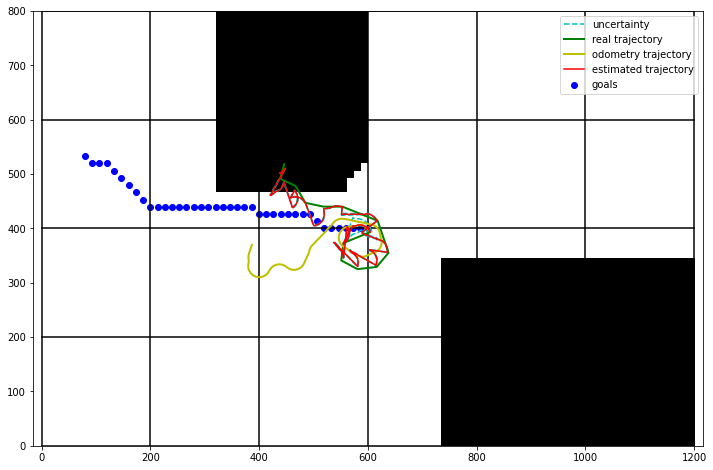

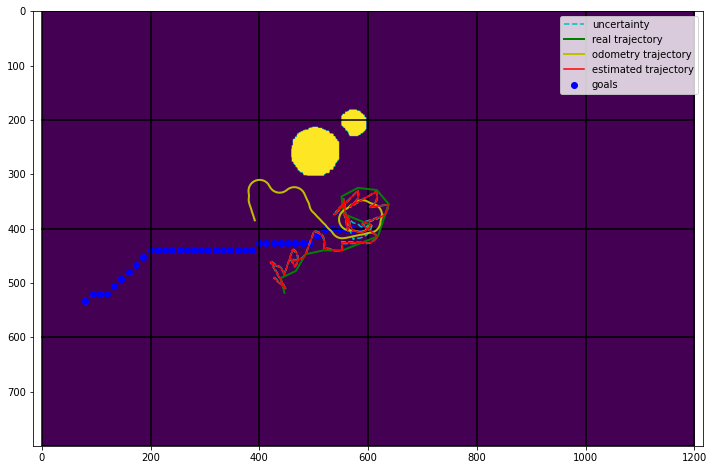

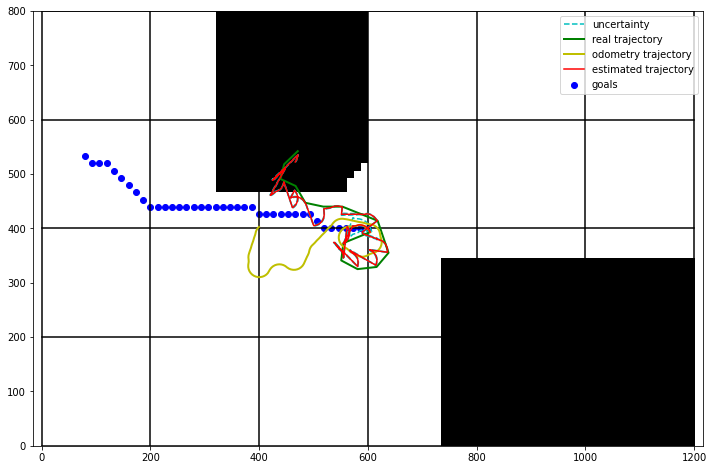

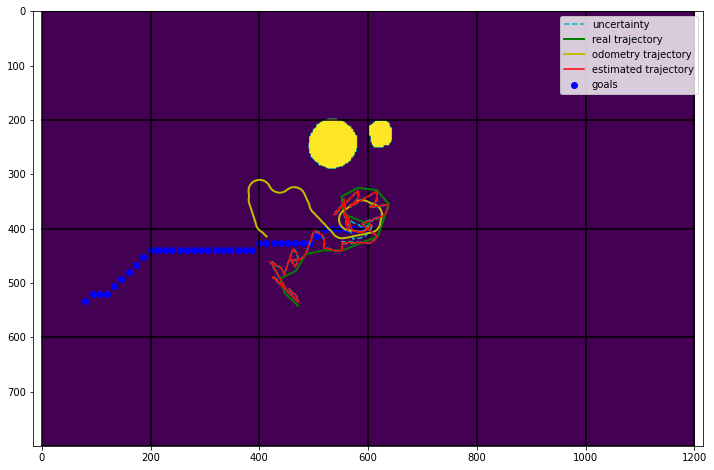

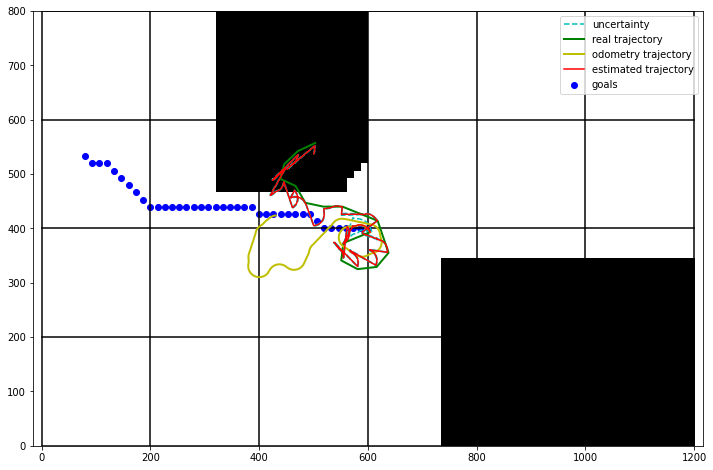

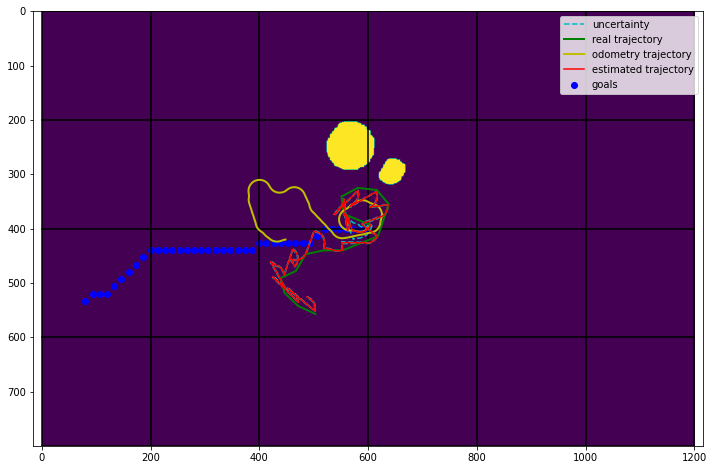

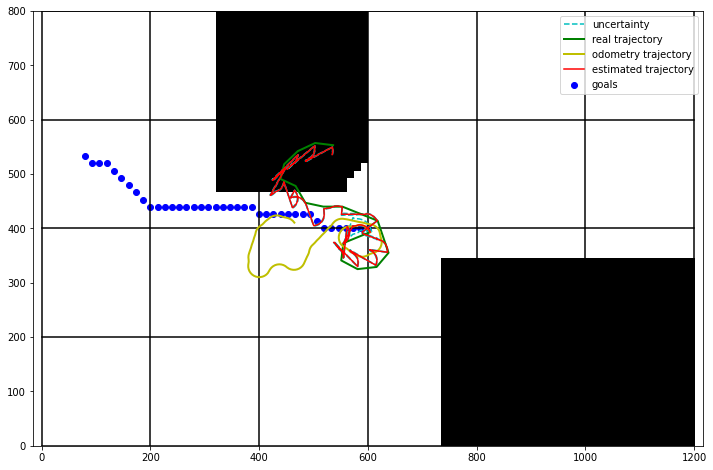

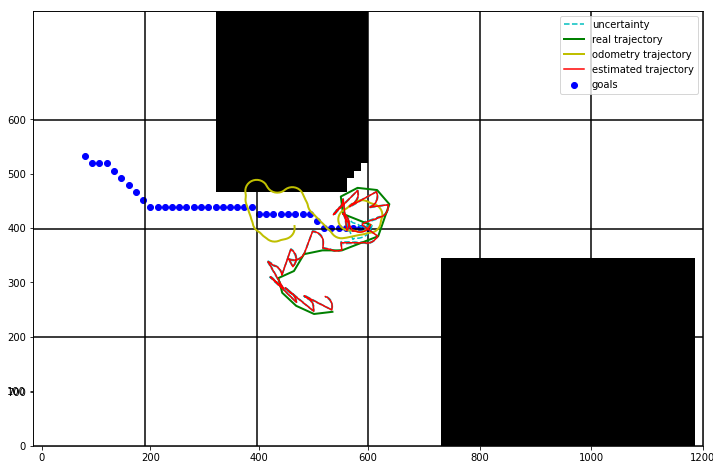

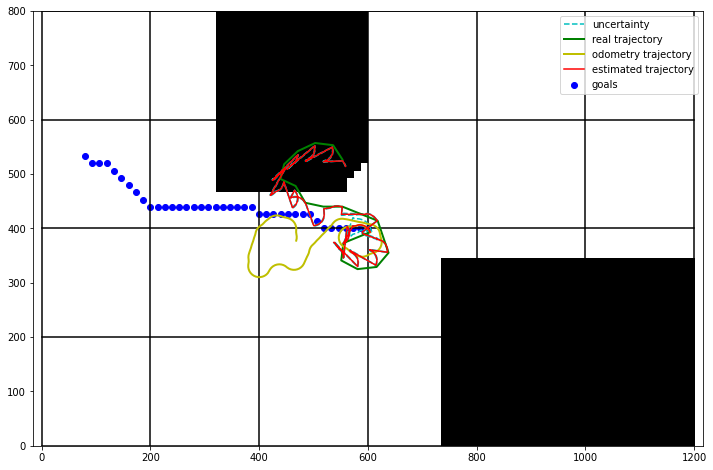

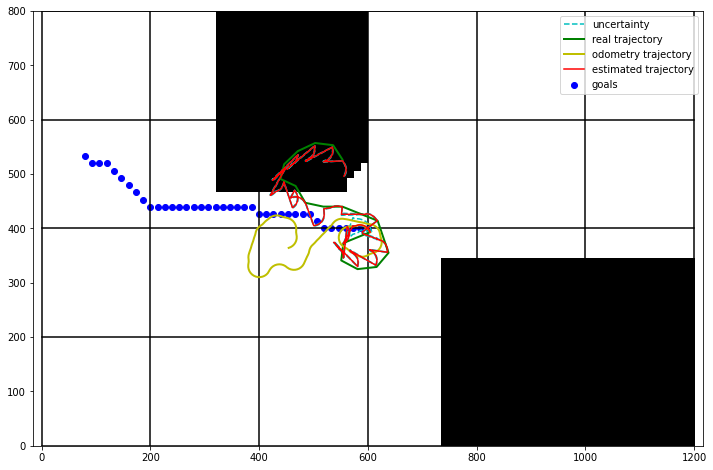

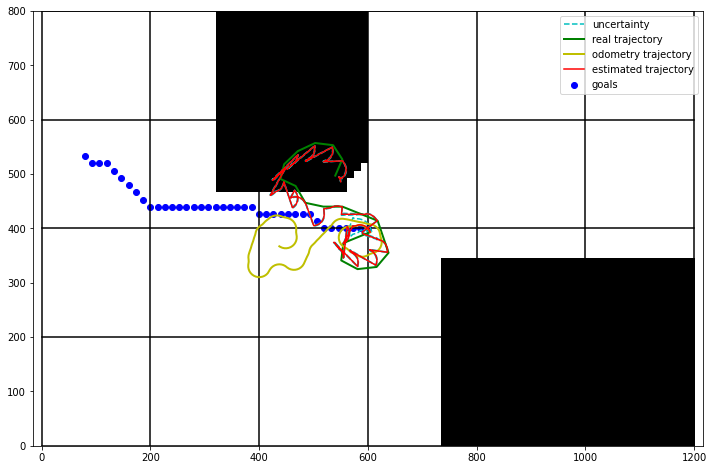

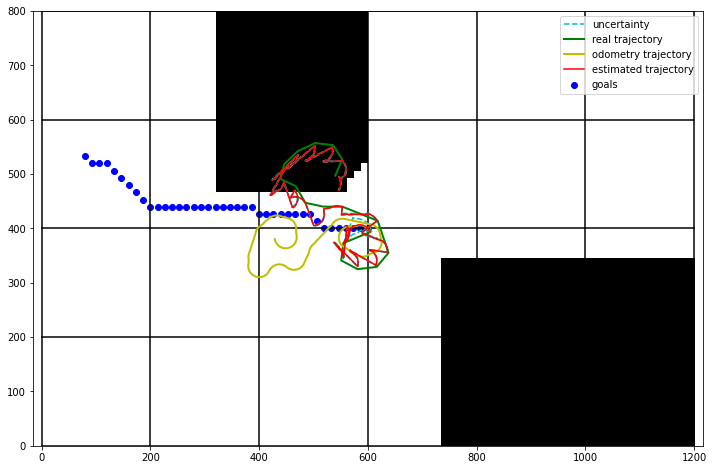

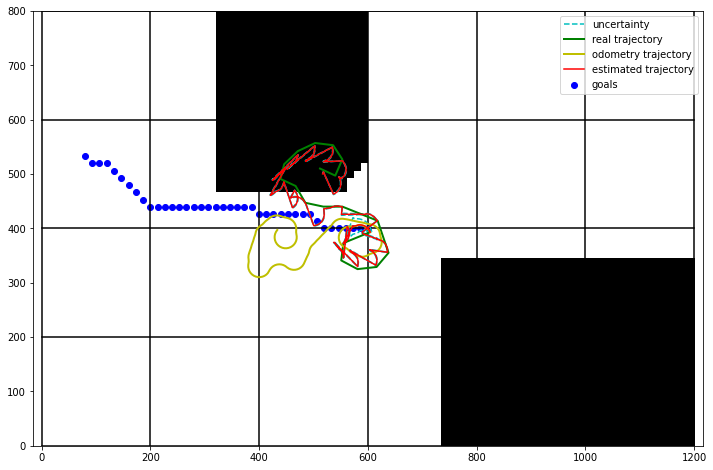

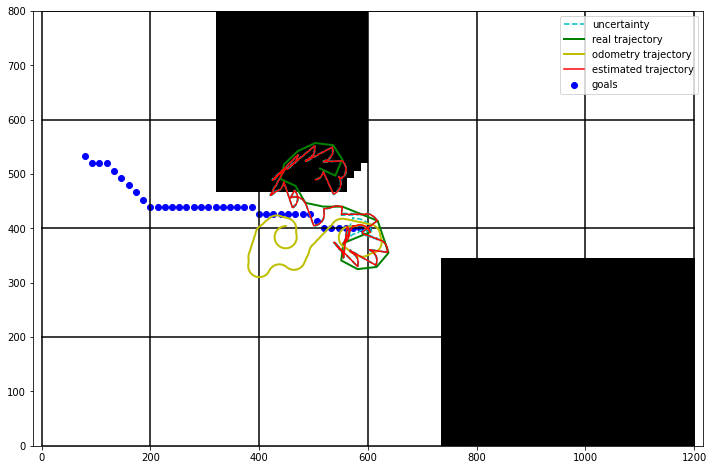

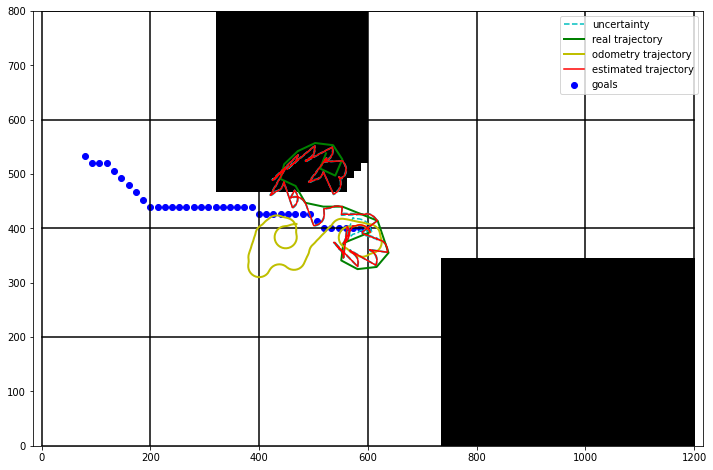

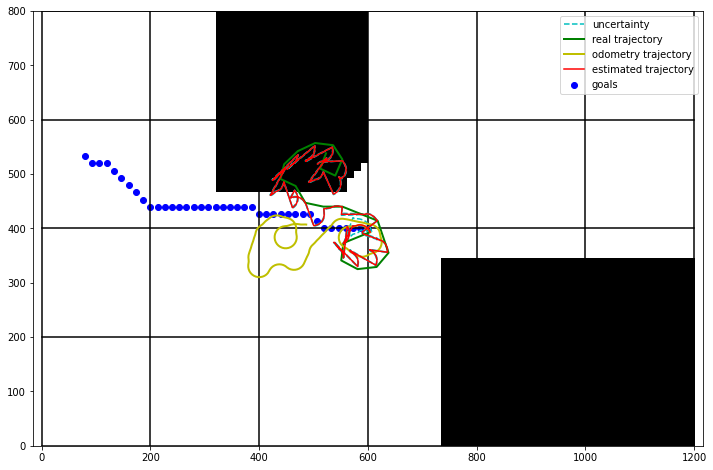

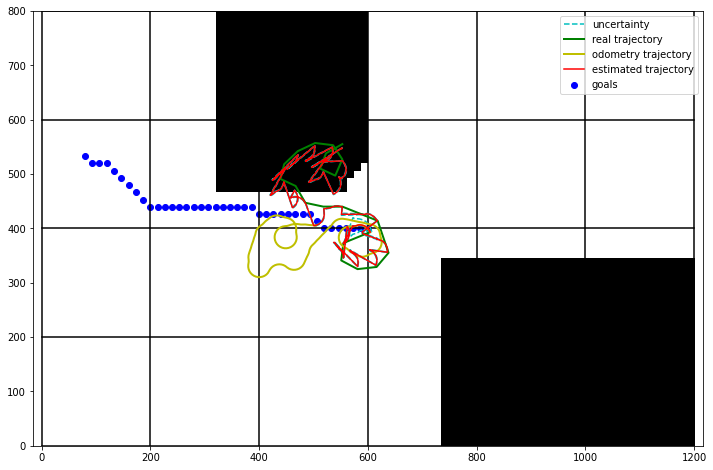

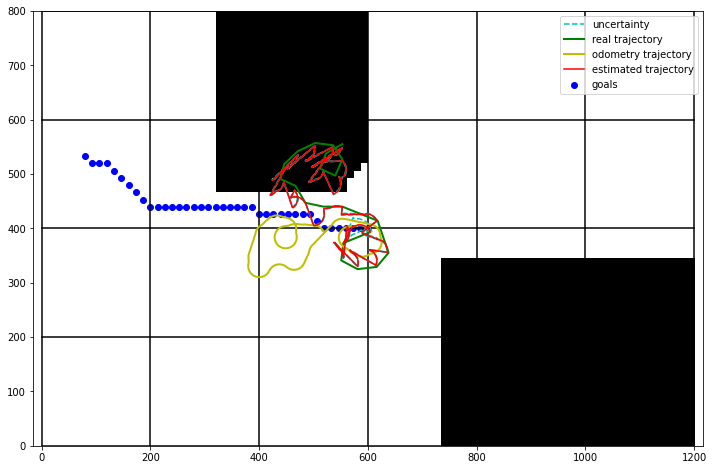

Exception in thread Thread-6319:
Traceback (most recent call last):
  File "c:\users\michael biselx\appdata\local\programs\python\python38-32\lib\threading.py", line 932, in _bootstrap_inner
    self.run()
  File "c:\users\michael biselx\appdata\local\programs\python\python38-32\lib\threading.py", line 1254, in run
    self.function(*self.args, **self.kwargs)
  File "<ipython-input-15-09611c5246a3>", line 15, in _run
  File "<ipython-input-41-ea4e665ff31f>", line 45, in camera_thread
  File "c:\users\michael biselx\appdata\local\programs\python\python38-32\lib\site-packages\matplotlib\pyplot.py", line 2731, in imshow
    sci(__ret)
  File "c:\users\michael biselx\appdata\local\programs\python\python38-32\lib\site-packages\matplotlib\pyplot.py", line 3102, in sci
    return gca()._sci(im)
  File "c:\users\michael biselx\appdata\local\programs\python\python38-32\lib\site-packages\matplotlib\axes\_base.py", line 1856, in _sci
    raise ValueError("Argument must be an image, collection, or

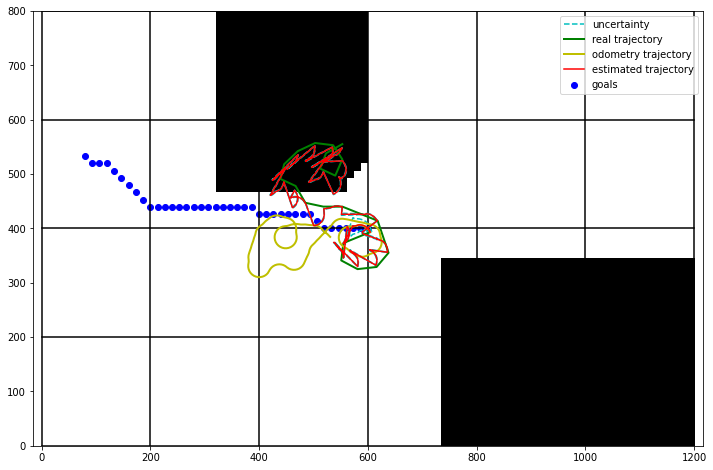

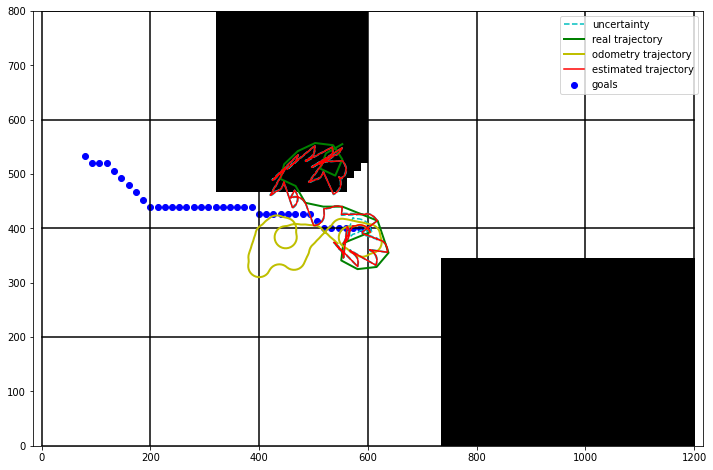

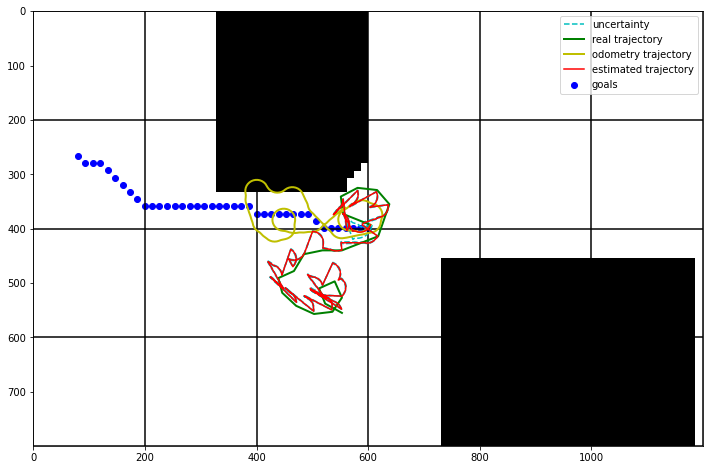

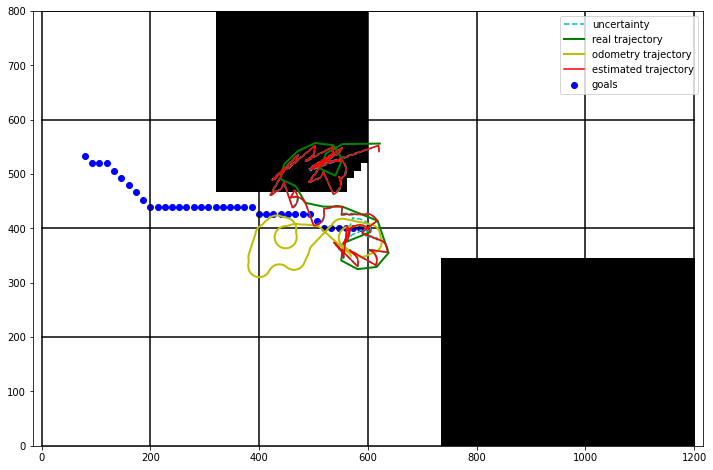

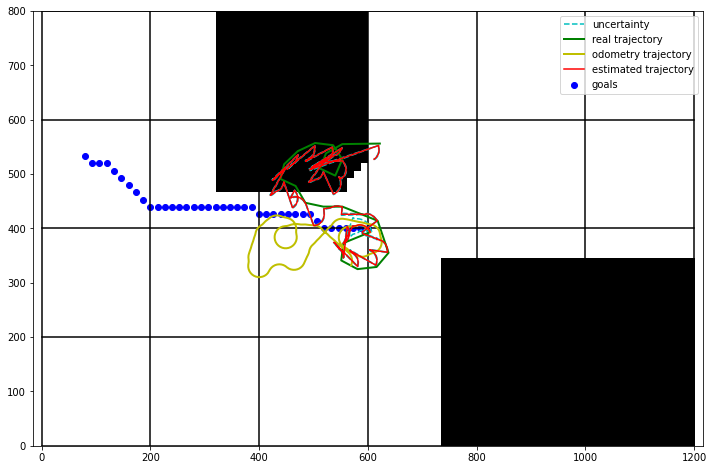

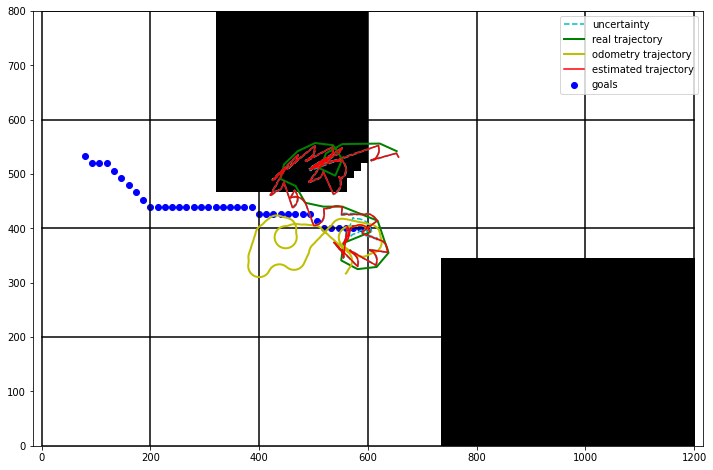

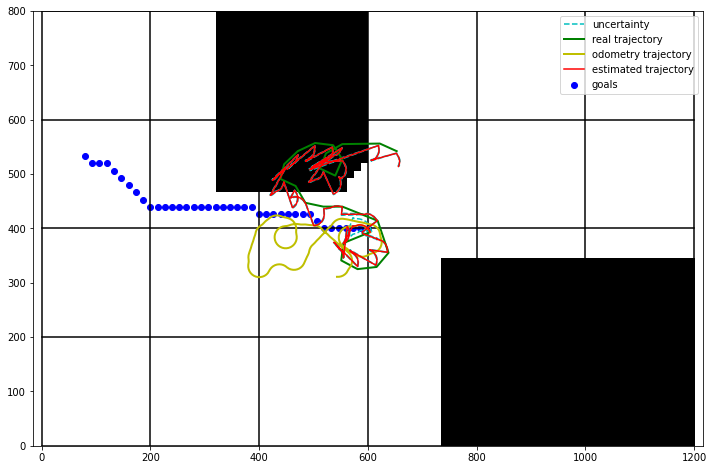

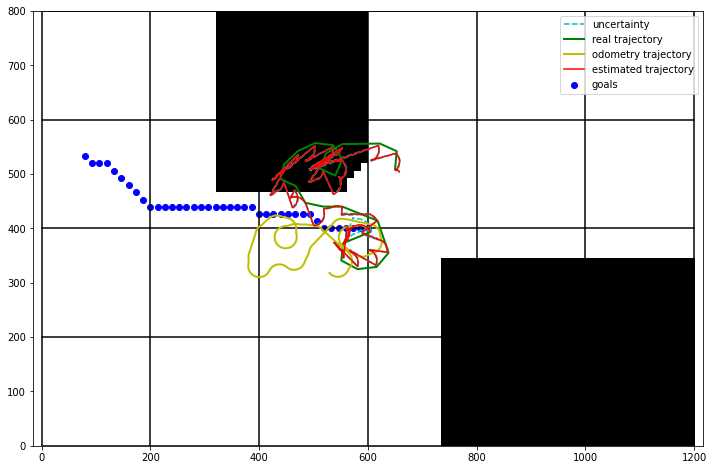

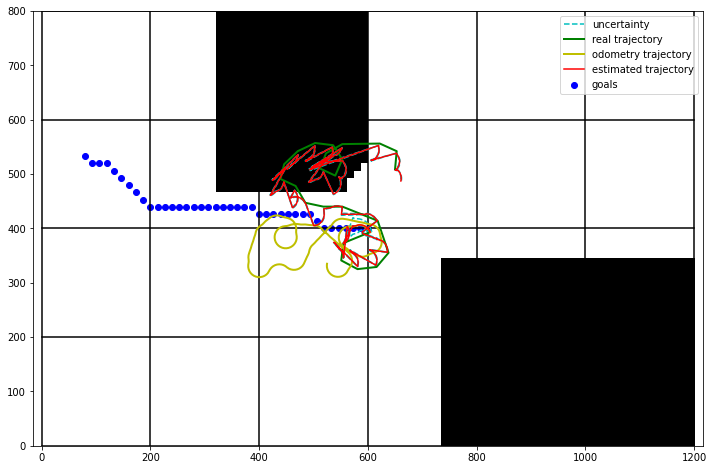

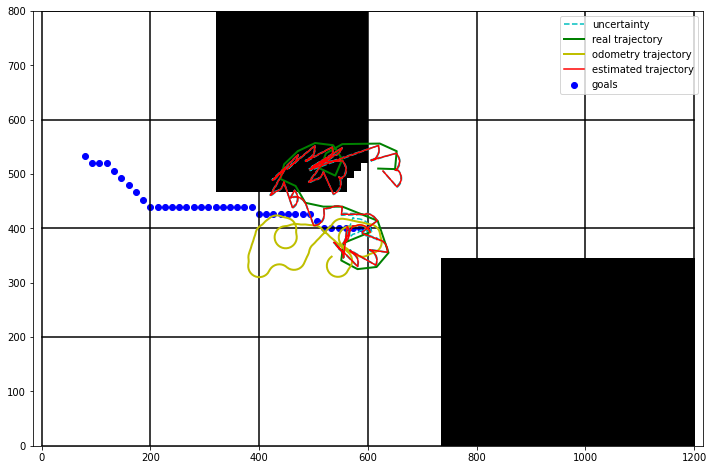

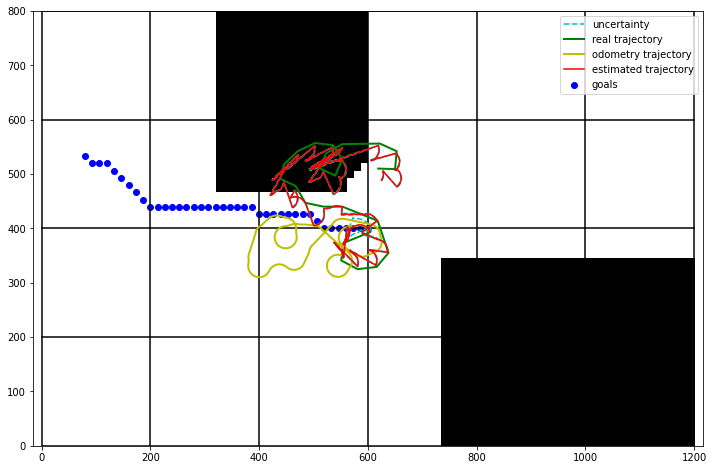

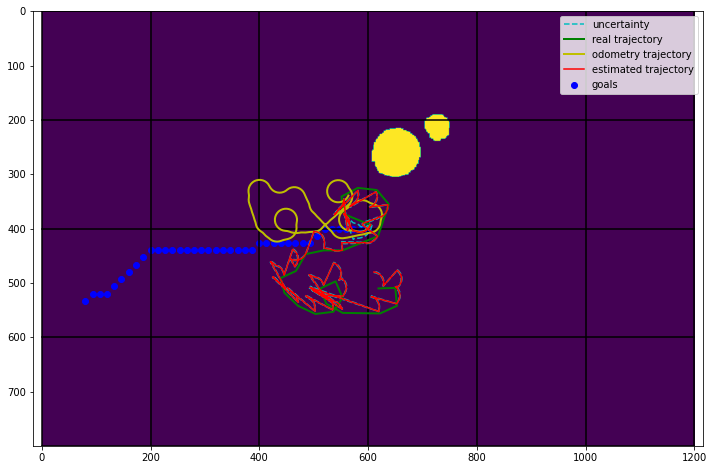

Done


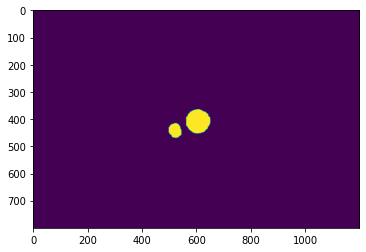

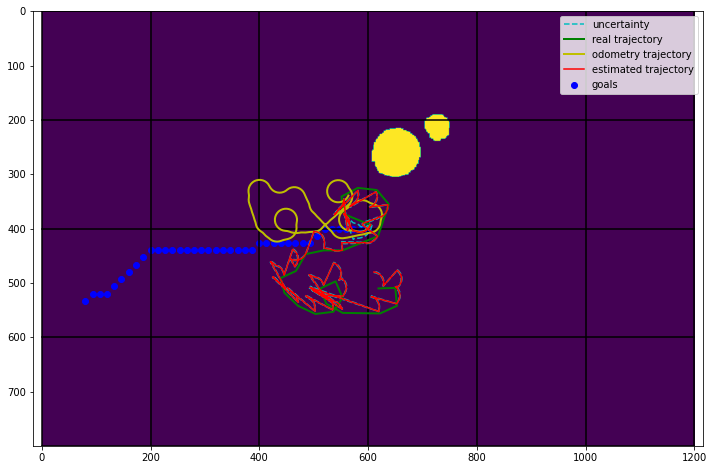

Exception in thread Thread-2894:
Traceback (most recent call last):
  File "c:\users\michael biselx\appdata\local\programs\python\python38-32\lib\threading.py", line 932, in _bootstrap_inner
    self.run()
  File "c:\users\michael biselx\appdata\local\programs\python\python38-32\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\Michael Biselx\Desktop\MobRob\basics-of-mobile-robotics\src\Thymio.py", line 340, in do_refresh
    self.get_variables()
  File "C:\Users\Michael Biselx\Desktop\MobRob\basics-of-mobile-robotics\src\Thymio.py", line 499, in get_variables
    self.send(msg)
  File "C:\Users\Michael Biselx\Desktop\MobRob\basics-of-mobile-robotics\src\Thymio.py", line 456, in send
    self.io.write(msg.serialize())
  File "c:\users\michael biselx\appdata\local\programs\python\python38-32\lib\site-packages\serial\serialwin32.py", line 323, in write
    raise writeTimeoutError
serial.serialutil.SerialTimeoutException: Write timeout


In [50]:
# setup vision
cap_size          = (1200, 1000)
global_shape      = (90,  60)
cap               = cv2.VideoCapture(1)                                         # put 1 if an external webcam is used
cap.set(3,cap_size[0])                                                          # width
cap.set(4,cap_size[1])                                                          # height
success, img      = cap.read()
plt.imshow(img)
#display(img)

true_map          = get_clean_map(img)

start = np.int32(robot_detection(true_map))
print(start)
cv2.rectangle(true_map, (start[0]-10, start[1]-10), (start[0]+10, start[1]+10), 255, 2)
display(true_map)


start             = util.rescale_int_coords(robot_detection(true_map), (true_map.shape[1], true_map.shape[0]), global_shape)  # starting point for global search
end               = util.rescale_int_coords(goal_detection(true_map),  (true_map.shape[1], true_map.shape[0]), global_shape)  # end point for global search
map_global_search = get_global_search_map(cv2.resize(true_map, global_shape))# apply resizing to reduce computation cost of global search

# setup global path finding
occupancy_grid    = np.flipud(np.asarray(map_global_search))                     # make occupancy grid and change coordinate system           
#occupancy_grid, _ = create_random_occupancy_grid(90,60)

path              = generate_global_path((occupancy_grid.shape[0]-start[1], start[0]), (occupancy_grid.shape[0]-end[1], end[0]), occupancy_grid)
path              = util.adapt_pathfinder_coords(path, field, occupancy_grid.shape)



# setup robot 
Tr = .2                                                                          # robot update timestep
Tc =  4                                                                          # camera update timestep

startpos    = util.adapt_vision_coords(robot_detection(true_map), field)         # starting point for pilot
robot.xhat  = startpos.copy()                                                    # setup robot
robot.xodo  = startpos.copy()
robot.s     = np.diag([1, 1, .2, 20, 20])**2

robot.d     = 90
robot.set_Ts(Tr)
robot.maxv  = 10
robot.maxw  = np.pi/32

field.goals = path
field.xreal = startpos.copy()                                                    # prepare record of (mis)deeds
field.xhat  = robot.xhat.copy()
field.xodo  = robot.xodo.copy()
field.s     = [2*np.sqrt(robot.s[0,0]+robot.s[1,1])]

goals       = np.ndarray.tolist(field.goals)

class Camera_Pos :
    def __init__ (self): 
        pass
camera_pos = Camera_Pos()
camera_pos.x = np.array([])                                                      # communication variable

rt = RepeatedTimer(Tr, robot_thread,  field, robot, goals, camera_pos);          # start threads
ct = RepeatedTimer(Tc, camera_thread, field, cap, camera_pos);

try:
    #print("Starting Run")  
    for i in range(60):
        time.sleep(1) 
        plt.clf();
        plt.gcf().set_size_inches(12,8)
        plt.imshow(occupancy_grid,cmap=colors.ListedColormap(['white', 'black']), origin = 'lower', extent=(field.xmin, field.xmax, field.ymin, field.ymax))
        field.plot()
        ds.display(plt.gcf())
        #ds.clear_output(wait=True)
        
        if not goals : 
            break

finally:
    rt.stop()
    ct.stop()
    robot.th.set_var("event.args", 2)
    robot.do_motion(np.zeros((2,1)))
    print("Done");

In [ ]:
ct.stop()

In [36]:
robot.do_motion(np.zeros((2,1)))
robot.th.close()

Exception in thread Thread-7:
Traceback (most recent call last):
  File "c:\users\michael biselx\appdata\local\programs\python\python38-32\lib\threading.py", line 932, in _bootstrap_inner
    self.run()
  File "c:\users\michael biselx\appdata\local\programs\python\python38-32\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\Michael Biselx\Desktop\MobRob\basics-of-mobile-robotics\src\Thymio.py", line 340, in do_refresh
    self.get_variables()
  File "C:\Users\Michael Biselx\Desktop\MobRob\basics-of-mobile-robotics\src\Thymio.py", line 499, in get_variables
    self.send(msg)
  File "C:\Users\Michael Biselx\Desktop\MobRob\basics-of-mobile-robotics\src\Thymio.py", line 456, in send
    self.io.write(msg.serialize())
  File "c:\users\michael biselx\appdata\local\programs\python\python38-32\lib\site-packages\serial\serialwin32.py", line 304, in write
    raise portNotOpenError
serial.serialutil.SerialException: Attempting to use a port that

In [ ]:
plt.imshow(occupancy_grid,cmap=colors.ListedColormap(['white', 'black']), origin = 'lower', extent=(field.xmin, field.xmax, field.ymin, field.ymax))
field.plot()
plt.gcf().set_size_inches(12,8)

In [20]:
cap.close()

AttributeError: 'cv2.VideoCapture' object has no attribute 'close'